## Libraries and file paths

In [203]:
from pathlib import Path
from tab_hero.dataio.tab_format import load_tab
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import (
    silhouette_score,
    homogeneity_score,
    completeness_score,
)
import matplotlib.pyplot as plt
from collections import Counter

In [3]:
dir_root = Path().cwd().parent
dir_preprocessed_data = dir_root / 'data' / 'processed'

## Source data

View preprocessed tab data

In [4]:
for i, tab_file in enumerate(dir_preprocessed_data.glob('*.tab')):
    print(tab_file)
    
    tab_data = load_tab(tab_file)
    
    print(tab_data)
    
    if i == 10:
        break

e:\Python Projects\tab-hero\data\processed\00025e292bfacc9b.tab
TabData(mel_spectrogram=array([[-2.8632812, -2.8632812, -2.8632812, ..., -2.8632812, -2.8632812,
        -2.8632812],
       [-2.8632812, -2.8632812, -2.8632812, ..., -2.8632812, -2.8632812,
        -2.8632812],
       [-2.8632812, -2.8632812, -2.8632812, ..., -2.8632812, -2.8632812,
        -2.8632812],
       ...,
       [-2.8632812, -2.8632812, -2.8632812, ..., -2.8632812, -2.8632812,
        -2.8632812],
       [-2.8632812, -2.8632812, -2.8632812, ..., -2.8632812, -2.8632812,
        -2.8632812],
       [-2.8632812, -2.8632812, -2.8632812, ..., -2.8632812, -2.8632812,
        -2.8632812]], shape=(128, 32688), dtype=float32), sample_rate=22050, hop_length=256, note_tokens=array([  1, 439, 505, ..., 631, 655,   2], shape=(1250,), dtype=int16), difficulty_id=0, instrument_id=2, content_hash='00025e292bfacc9b', genre_id=1, song_id=3809)
e:\Python Projects\tab-hero\data\processed\0003cad26b028e39.tab
TabData(mel_spectrogram

In [5]:
for i, tab_file in enumerate(dir_preprocessed_data.iterdir()):
    print(tab_file)
    
    if i == 10:
        break

e:\Python Projects\tab-hero\data\processed\.mel_cache
e:\Python Projects\tab-hero\data\processed\.progress_manifest.json
e:\Python Projects\tab-hero\data\processed\00025e292bfacc9b.tab
e:\Python Projects\tab-hero\data\processed\0003cad26b028e39.tab
e:\Python Projects\tab-hero\data\processed\00044d42d97be12d.tab
e:\Python Projects\tab-hero\data\processed\0005aa02866dddf6.tab
e:\Python Projects\tab-hero\data\processed\0005cc1d3cbc5253.tab
e:\Python Projects\tab-hero\data\processed\00068c50bf7a2a95.tab
e:\Python Projects\tab-hero\data\processed\0006ec38aac643a5.tab
e:\Python Projects\tab-hero\data\processed\000964b8f367c35e.tab
e:\Python Projects\tab-hero\data\processed\000bd4b91be58246.tab


In [6]:
pd.set_option('display.max_columns', None)

In [7]:
sample_100 = pd.read_csv(dir_root / 'sample_features.csv').sort_values(by='song_id')
sample_100

,content_hash,difficulty_id,instrument_id,genre_id,song_id,duration_sec,rms_energy_mean,rms_energy_std,amplitude_envelope_min,amplitude_envelope_max,amplitude_envelope_range,tempo_bpm,mel_rms_mean,mel_rms_std,spectral_centroid_mean,n_notes,notes_per_second_mean,inter_note_ms_mean,inter_note_ms_std,inter_note_ms_median,inter_note_ms_p25,inter_note_ms_p75,sustain_ratio,chord_ratio,fret_entropy,hopo_ratio,star_power_ratio,tap_ratio
74,47eeb854c2a69d56,0,2,1,322,163.363991,1.569240,0.451045,0.013296,2.587504,2.574208,99.384014,1.569240,0.451045,52.368206,125,0.765163,1244.354839,770.937052,1200.0,600.0,1200.0,0.336000,0.016000,0.692372,1.000000,0.200000,0.000000
6,e924eea23ea77a15,1,2,7,370,301.116372,1.751260,0.645892,0.068585,3.073434,3.004850,161.499023,1.751260,0.645892,47.940368,552,1.833178,438.802178,400.848939,370.0,370.0,370.0,0.112319,0.380435,1.438621,0.996377,0.123188,0.000000
0,237b10b35cabd811,2,0,1,472,179.350930,2.334718,0.695964,0.006338,3.727419,3.721081,123.046875,2.334718,0.695964,45.125053,378,2.107600,434.641910,482.719355,320.0,160.0,320.0,0.108466,0.148148,1.320973,0.000000,0.169312,0.000000
7,e78fe96c3ad65293,1,0,5,515,207.075556,1.774428,0.618449,0.006738,3.239375,3.232637,161.499023,1.774428,0.618449,53.026571,422,2.037904,471.520190,377.532390,370.0,370.0,370.0,0.066351,0.616114,1.359151,0.000000,0.139810,0.000000
91,dc96c598e1e23f8f,2,2,2,628,231.293968,1.515922,0.446119,0.027122,2.372350,2.345228,112.347147,1.515922,0.446119,54.638899,813,3.515007,254.359606,228.194798,170.0,170.0,350.0,0.029520,0.341943,1.345560,0.000000,0.111931,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12,ab340ef876ae6e26,2,2,1,6702,196.011247,1.765618,0.455689,0.028758,3.459470,3.430711,147.656250,1.765618,0.455689,53.057743,558,2.846775,337.199282,313.168870,200.0,200.0,410.0,0.057348,0.426523,1.501688,0.000000,0.258065,0.014337
39,0208c2b4e58d0c81,1,0,3,6728,291.561361,1.504532,0.530520,0.071736,2.391033,2.319297,103.359375,1.504532,0.530520,56.869233,605,2.075035,431.357616,243.526406,380.0,380.0,380.0,0.004959,0.980165,1.354966,0.000000,0.099174,0.000000
40,84c1d9a8207ef014,0,0,12,6749,172.942222,1.870214,1.012995,0.113964,4.809110,4.695146,123.046875,1.870214,1.012995,50.941792,133,0.769043,1149.242424,677.088935,1005.0,740.0,1230.0,0.015038,0.000000,1.160769,0.000000,0.082707,0.000000
25,086cc80aa2543992,3,2,2,6933,269.897143,1.647391,0.445084,0.086530,2.550247,2.463718,109.956782,1.647391,0.445084,53.073522,1332,4.935213,190.646131,230.638620,130.0,130.0,140.0,0.113363,0.160661,1.551042,0.488739,0.000000,0.511261


In [8]:
for col in sample_100.columns:
    print(col)

content_hash
difficulty_id
instrument_id
genre_id
song_id
duration_sec
rms_energy_mean
rms_energy_std
amplitude_envelope_min
amplitude_envelope_max
amplitude_envelope_range
tempo_bpm
mel_rms_mean
mel_rms_std
spectral_centroid_mean
n_notes
notes_per_second_mean
inter_note_ms_mean
inter_note_ms_std
inter_note_ms_median
inter_note_ms_p25
inter_note_ms_p75
sustain_ratio
chord_ratio
fret_entropy
hopo_ratio
star_power_ratio
tap_ratio


## Base dataset

In [9]:
full = pd.read_csv(dir_root / 'features.csv')
full.head(100)

,content_hash,difficulty_id,instrument_id,genre_id,song_id,duration_sec,rms_energy_mean,rms_energy_std,amplitude_envelope_min,amplitude_envelope_max,amplitude_envelope_range,tempo_bpm,mel_rms_mean,mel_rms_std,spectral_centroid_mean,n_notes,notes_per_second_mean,inter_note_ms_mean,inter_note_ms_std,inter_note_ms_median,inter_note_ms_p25,inter_note_ms_p75,sustain_ratio,chord_ratio,fret_entropy,hopo_ratio,star_power_ratio,tap_ratio
0,00068c50bf7a2a95,0,2,7,3631,163.480091,1.891090,1.430148,0.402069,4.052784,3.650716,143.554688,1.891090,1.430148,55.777028,96,0.587227,994.736842,742.686223,830.0,820.0,830.0,0.041667,0.000000,1.107923,0.000000,0.104167,0.000000
1,00044d42d97be12d,0,2,4,1694,194.292971,1.687803,0.795066,0.098820,2.682918,2.584098,112.347147,1.687803,0.795066,51.654273,148,0.761736,1254.829932,564.478392,1060.0,1050.0,1085.0,0.378378,0.000000,0.986289,0.000000,0.189189,0.000000
2,000964b8f367c35e,1,0,1,2603,234.289342,1.612189,0.821523,0.178069,3.146025,2.967956,139.674831,1.612189,0.821523,59.742395,251,1.071325,722.640000,571.584666,530.0,420.0,850.0,0.294821,0.406375,1.468277,0.996016,0.258964,0.000000
3,0006ec38aac643a5,0,0,1,2614,234.033923,1.715760,0.565870,0.134545,2.594404,2.459859,139.674831,1.715760,0.565870,49.109248,156,0.666570,1337.419355,430.661665,1270.0,880.0,1705.0,0.153846,0.000000,1.131019,0.993590,0.224359,0.000000
4,0005cc1d3cbc5253,2,1,3,340,247.118367,3.104284,1.243821,0.271522,6.126035,5.854513,117.453835,3.104284,1.243821,34.718610,420,1.699590,529.451074,580.585199,250.0,250.0,510.0,0.111905,0.690476,1.583723,0.990476,0.119048,0.002381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0082139b1aedc2f1,2,0,1,6738,207.377415,1.687693,0.816365,0.109384,3.047493,2.938109,123.046875,1.687693,0.816365,53.583222,346,1.668456,528.869565,440.972112,240.0,240.0,960.0,0.049133,0.274566,1.416768,0.000000,0.112717,0.147399
96,0081bd1ab8ec75f0,3,0,3,2451,345.327166,1.588202,0.412583,0.036142,2.074820,2.038678,120.185320,1.588202,0.412583,52.458733,1207,3.495236,261.791045,209.461386,160.0,160.0,330.0,0.167357,0.349627,1.531770,0.990058,0.096935,0.009114
97,0085a4f150fd3a93,0,3,8,6034,230.330340,2.201571,1.157041,0.052586,6.374375,6.321790,123.046875,2.201571,1.157041,46.057842,211,0.916076,1021.333333,620.615772,960.0,720.0,1200.0,0.241706,0.000000,1.145157,0.000000,0.184834,0.009479
98,008881880a51dd3b,1,2,1,4863,210.001270,1.656396,0.519947,0.058778,2.412222,2.353444,151.999081,1.656396,0.519947,52.640956,415,1.976179,480.362319,311.669362,390.0,380.0,390.0,0.115663,0.272289,1.344770,0.000000,0.120482,0.000000


In [10]:
full.loc[full.song_id == 1, 'difficulty_id']

2579     3
36520    3
Name: difficulty_id, dtype: int64

## Cleaning

### Identify song-instrument level data

Confirm which columns contain consistent values across each song-instrument set (set of difficulties)

In [11]:
songs = full.song_id.unique()
instruments = np.arange(0, 4)
difficulties = np.arange(0, 4)

NUM_SONGS_AND_INSTRUMENTS = len(full.loc[:, ['song_id', 'instrument_id']].drop_duplicates())
print(NUM_SONGS_AND_INSTRUMENTS)

consistent_cols = ['song_id', 'instrument_id']

for col in full.columns:
    
    if col in consistent_cols:
        continue
    
    cols_to_check = consistent_cols + [col]
    
    curr_n_rows = len(full.loc[:, cols_to_check].drop_duplicates())
    
    if curr_n_rows == NUM_SONGS_AND_INSTRUMENTS:
        consistent_cols.append(col)

print(consistent_cols)

full.loc[:, consistent_cols].drop_duplicates().sort_values(by=['song_id', 'instrument_id'])

14059
['song_id', 'instrument_id', 'genre_id', 'duration_sec', 'rms_energy_mean', 'rms_energy_std', 'amplitude_envelope_min', 'amplitude_envelope_max', 'amplitude_envelope_range', 'tempo_bpm', 'mel_rms_mean', 'mel_rms_std', 'spectral_centroid_mean']


,song_id,instrument_id,genre_id,duration_sec,rms_energy_mean,rms_energy_std,amplitude_envelope_min,amplitude_envelope_max,amplitude_envelope_range,tempo_bpm,mel_rms_mean,mel_rms_std,spectral_centroid_mean
2579,1,0,1,209.304671,1.548575,0.505502,0.068546,2.348098,2.279552,126.048018,1.548575,0.505502,54.275942
36520,1,2,1,209.304671,1.548575,0.505502,0.068546,2.348098,2.279552,126.048018,1.548575,0.505502,54.275942
31815,2,0,1,332.103401,1.764526,0.385264,0.017125,2.788346,2.771221,129.199219,1.764526,0.385264,54.642545
53060,3,0,4,234.068753,1.705167,0.595139,0.114186,2.873486,2.759300,129.199219,1.705167,0.595139,49.077235
43658,3,2,4,234.068753,1.705167,0.595139,0.114186,2.873486,2.759300,129.199219,1.705167,0.595139,49.077235
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11480,6946,1,2,519.418776,2.341415,0.794711,0.275529,3.484388,3.208859,105.468750,2.341415,0.794711,36.879245
47347,6946,2,2,519.418776,1.692970,0.476703,0.056970,2.968671,2.911701,105.468750,1.692970,0.476703,53.982015
5088,6947,0,1,260.794921,1.746991,0.615512,0.088409,3.028933,2.940524,135.999178,1.746991,0.615512,47.560377
7410,6947,1,1,260.794921,2.632053,0.898390,0.227976,5.149873,4.921897,135.999178,2.632053,0.898390,35.320079


### Confirm the number of difficulties is the same for each instrument in a song

In [12]:
diff_per_instrument = full.loc[:, ['song_id', 'instrument_id', 'difficulty_id']].groupby(['song_id', 'instrument_id']).agg(max)
assert len(diff_per_instrument.reset_index().drop_duplicates()) == NUM_SONGS_AND_INSTRUMENTS

### Keep only the highest difficulty values within each song-instrument group

In [13]:
# Use this pairing as a map; there isn't the same number of difficulties per song
highest_diff_per_song_map = full.loc[:, ['song_id', 'instrument_id', 'difficulty_id']].groupby(['song_id', 'instrument_id']).agg(max)
highest_diff_per_song_map.reset_index()

,song_id,instrument_id,difficulty_id
0,1,0,3
1,1,2,3
2,2,0,3
3,3,0,3
4,3,2,3
...,...,...,...
14054,6946,1,3
14055,6946,2,3
14056,6947,0,3
14057,6947,1,3


In [14]:
song_and_instrument_df = pd.merge(highest_diff_per_song_map, full, how="inner", on=['song_id', 'instrument_id', 'difficulty_id'])
song_and_instrument_df

,song_id,instrument_id,difficulty_id,content_hash,genre_id,duration_sec,rms_energy_mean,rms_energy_std,amplitude_envelope_min,amplitude_envelope_max,amplitude_envelope_range,tempo_bpm,mel_rms_mean,mel_rms_std,spectral_centroid_mean,n_notes,notes_per_second_mean,inter_note_ms_mean,inter_note_ms_std,inter_note_ms_median,inter_note_ms_p25,inter_note_ms_p75,sustain_ratio,chord_ratio,fret_entropy,hopo_ratio,star_power_ratio,tap_ratio
0,1,0,3,0c97fc5477d68ce4,1,209.304671,1.548575,0.505502,0.068546,2.348098,2.279552,126.048018,1.548575,0.505502,54.275942,727,3.473406,270.743802,298.965154,230.0,110.0,230.0,0.066025,0.232462,1.462783,0.024759,0.207703,0.006878
1,1,2,3,aef66f85c7c25a75,1,209.304671,1.548575,0.505502,0.068546,2.348098,2.279552,126.048018,1.548575,0.505502,54.275942,727,3.473406,270.743802,298.965154,230.0,110.0,230.0,0.066025,0.232462,1.462783,0.024759,0.207703,0.006878
2,2,0,3,98525b0874047934,1,332.103401,1.764526,0.385264,0.017125,2.788346,2.771221,129.199219,1.764526,0.385264,54.642545,1064,3.203821,298.635936,292.446330,230.0,230.0,450.0,0.250000,0.456767,1.743888,0.000000,0.102444,0.000000
3,3,0,3,fe745ba605aa02d7,4,234.068753,1.705167,0.595139,0.114186,2.873486,2.759300,129.199219,1.705167,0.595139,49.077235,1208,5.160877,178.765534,196.813599,110.0,70.0,230.0,0.037252,0.233444,1.570867,0.067881,0.144868,0.246689
4,3,2,3,d19feff63b213786,4,234.068753,1.705167,0.595139,0.114186,2.873486,2.759300,129.199219,1.705167,0.595139,49.077235,1208,5.160877,178.765534,196.813599,110.0,70.0,230.0,0.037252,0.233444,1.570867,0.067881,0.144868,0.246689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14054,6946,1,3,fd52baa8aa1b5269,2,519.418776,2.341415,0.794711,0.275529,3.484388,3.208859,105.468750,2.341415,0.794711,36.879245,2412,4.643652,199.174616,243.071608,140.0,140.0,170.0,0.069237,0.000000,1.367596,0.887645,0.171227,0.112355
14055,6946,2,3,e2cd196b477da1f1,2,519.418776,1.692970,0.476703,0.056970,2.968671,2.911701,105.468750,1.692970,0.476703,53.982015,2505,4.822698,194.820288,198.697756,140.0,140.0,180.0,0.075050,0.249501,1.490730,0.967665,0.000000,0.032335
14056,6947,0,3,d7ae3f061e1441cc,1,260.794921,1.746991,0.615512,0.088409,3.028933,2.940524,135.999178,1.746991,0.615512,47.560377,906,3.473994,272.563536,182.182753,220.0,220.0,220.0,0.248344,0.322296,1.535464,0.896247,0.163355,0.103753
14057,6947,1,3,24026653c3593c70,1,260.794921,2.632053,0.898390,0.227976,5.149873,4.921897,135.999178,2.632053,0.898390,35.320079,829,3.178743,280.446860,232.567414,220.0,220.0,220.0,0.171291,0.000000,1.443048,0.913148,0.160434,0.086852


In [15]:
# no longer need difficulty_id
song_and_instrument_df.drop('difficulty_id', axis=1, inplace=True)
song_and_instrument_df

,song_id,instrument_id,content_hash,genre_id,duration_sec,rms_energy_mean,rms_energy_std,amplitude_envelope_min,amplitude_envelope_max,amplitude_envelope_range,tempo_bpm,mel_rms_mean,mel_rms_std,spectral_centroid_mean,n_notes,notes_per_second_mean,inter_note_ms_mean,inter_note_ms_std,inter_note_ms_median,inter_note_ms_p25,inter_note_ms_p75,sustain_ratio,chord_ratio,fret_entropy,hopo_ratio,star_power_ratio,tap_ratio
0,1,0,0c97fc5477d68ce4,1,209.304671,1.548575,0.505502,0.068546,2.348098,2.279552,126.048018,1.548575,0.505502,54.275942,727,3.473406,270.743802,298.965154,230.0,110.0,230.0,0.066025,0.232462,1.462783,0.024759,0.207703,0.006878
1,1,2,aef66f85c7c25a75,1,209.304671,1.548575,0.505502,0.068546,2.348098,2.279552,126.048018,1.548575,0.505502,54.275942,727,3.473406,270.743802,298.965154,230.0,110.0,230.0,0.066025,0.232462,1.462783,0.024759,0.207703,0.006878
2,2,0,98525b0874047934,1,332.103401,1.764526,0.385264,0.017125,2.788346,2.771221,129.199219,1.764526,0.385264,54.642545,1064,3.203821,298.635936,292.446330,230.0,230.0,450.0,0.250000,0.456767,1.743888,0.000000,0.102444,0.000000
3,3,0,fe745ba605aa02d7,4,234.068753,1.705167,0.595139,0.114186,2.873486,2.759300,129.199219,1.705167,0.595139,49.077235,1208,5.160877,178.765534,196.813599,110.0,70.0,230.0,0.037252,0.233444,1.570867,0.067881,0.144868,0.246689
4,3,2,d19feff63b213786,4,234.068753,1.705167,0.595139,0.114186,2.873486,2.759300,129.199219,1.705167,0.595139,49.077235,1208,5.160877,178.765534,196.813599,110.0,70.0,230.0,0.037252,0.233444,1.570867,0.067881,0.144868,0.246689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14054,6946,1,fd52baa8aa1b5269,2,519.418776,2.341415,0.794711,0.275529,3.484388,3.208859,105.468750,2.341415,0.794711,36.879245,2412,4.643652,199.174616,243.071608,140.0,140.0,170.0,0.069237,0.000000,1.367596,0.887645,0.171227,0.112355
14055,6946,2,e2cd196b477da1f1,2,519.418776,1.692970,0.476703,0.056970,2.968671,2.911701,105.468750,1.692970,0.476703,53.982015,2505,4.822698,194.820288,198.697756,140.0,140.0,180.0,0.075050,0.249501,1.490730,0.967665,0.000000,0.032335
14056,6947,0,d7ae3f061e1441cc,1,260.794921,1.746991,0.615512,0.088409,3.028933,2.940524,135.999178,1.746991,0.615512,47.560377,906,3.473994,272.563536,182.182753,220.0,220.0,220.0,0.248344,0.322296,1.535464,0.896247,0.163355,0.103753
14057,6947,1,24026653c3593c70,1,260.794921,2.632053,0.898390,0.227976,5.149873,4.921897,135.999178,2.632053,0.898390,35.320079,829,3.178743,280.446860,232.567414,220.0,220.0,220.0,0.171291,0.000000,1.443048,0.913148,0.160434,0.086852


### Incosistent song lengths

There are several songs who have inconsistent `duration_sec` values across each record they appear in.

In [16]:
# Find these songs
inconsistent_dur = song_and_instrument_df.loc[:, ['song_id', 'duration_sec']].drop_duplicates().groupby('song_id').agg(list)
inconsistent_dur.loc[:, '_len'] = inconsistent_dur.loc[:, 'duration_sec'].apply(lambda x: len(x))
inconsistent_dur = inconsistent_dur.loc[inconsistent_dur._len > 1, :]

# Display the songs
relevant_columns = ['song_id', 'instrument_id', 'duration_sec']
inconsistent_dur = song_and_instrument_df.loc[song_and_instrument_df.song_id.isin(inconsistent_dur.index), relevant_columns].sort_values(by=relevant_columns)

# Save the indices
inconsistent_dur = inconsistent_dur.reset_index(names="record_index")

inconsistent_dur.head(10)

,record_index,song_id,instrument_id,duration_sec
0,2279,1384,0,224.002902
1,2280,1384,2,224.002902
2,2281,1384,3,223.991293
3,3928,2151,0,262.002358
4,3929,2151,1,262.013968
5,3930,2151,2,262.002358
6,6131,3156,0,74.094875
7,6132,3156,1,74.001995
8,6133,3156,2,74.094875
9,6134,3156,3,74.094875


Identify the "worst" duration for a song by the least popular option, or whichever is first if there are ties

In [17]:
relevant_columns = ['song_id', 'duration_sec', 'record_index']
groupby_columns = ['song_id', 'duration_sec']

# Count occurences, and track the indices in each group
agg_mapper = {
    'duration_sec': 'size',
    'record_index': list
}
duration_counts = inconsistent_dur.loc[:, relevant_columns].groupby(groupby_columns).agg(agg_mapper)
duration_counts.columns = ['counts', 'indices']
duration_counts.reset_index(inplace=True)


worst_durations = duration_counts.sort_values(by=['song_id', 'counts']).explode('indices')#.drop_duplicates(subset=['song_id'])
# Gather all but last indices within each song
all_but_last_song_index = worst_durations.duplicated(subset='song_id', keep='last')
worst_indices = worst_durations.loc[all_but_last_song_index].loc[:, 'indices']
worst_indices

0      2281
1      2279
3      3929
2      3928
4      6132
      ...  
60    12788
62    12863
63    12861
65    12933
64    12931
Name: indices, Length: 68, dtype: object

In [18]:
prev_len = len(song_and_instrument_df)
song_and_instrument_df = song_and_instrument_df.loc[~song_and_instrument_df.index.isin(worst_indices)]
curr_len = len(song_and_instrument_df)

print(f"We have removed {prev_len-curr_len} records")

We have removed 68 records


Confirm that there are now no duplicate records

In [19]:
song_and_instrument_counts = song_and_instrument_df.loc[:, ['song_id', 'instrument_id']].drop_duplicates().groupby(['song_id', 'instrument_id']).agg('size')
assert np.array([1]) == song_and_instrument_counts.reset_index(name='counts').counts.unique()

### Handle suspicious data

There is a batch of instrument records that are indicated to have less than 20 notes in an entire song. It would make more sense to remove these songs entirely, because this indicates that the instrument parser and/or chart generator had difficulty distinguishing/identifying the actual instrument(s) in the song. This would result in removing 20 songs from consideration. This is meaningful, because we can also see that there aren't any instrument records with note counts greater than 20, that have `inter_note_ms_mean` values less than 1ms.

In [20]:
less_than_20 = song_and_instrument_df.loc[song_and_instrument_df.n_notes.lt(20), :].sort_values(by='instrument_id').reset_index(drop=True)
print(len(less_than_20))
print(len(less_than_20.song_id.unique()))
less_than_20.head()

39
31


,song_id,instrument_id,content_hash,genre_id,duration_sec,rms_energy_mean,rms_energy_std,amplitude_envelope_min,amplitude_envelope_max,amplitude_envelope_range,tempo_bpm,mel_rms_mean,mel_rms_std,spectral_centroid_mean,n_notes,notes_per_second_mean,inter_note_ms_mean,inter_note_ms_std,inter_note_ms_median,inter_note_ms_p25,inter_note_ms_p75,sustain_ratio,chord_ratio,fret_entropy,hopo_ratio,star_power_ratio,tap_ratio
0,2208,0,522c0a9e6357df4e,1,81.258231,1.631713,0.730619,0.156227,2.602316,2.446089,132.512019,1.631713,0.730619,57.708629,17,0.209210,3545.625000,944.040311,3995.0,3125.0,4000.0,1.0,0.0,1.095078e+00,0.0,0.0,0.0
1,2203,0,845470251a32bc62,1,81.258231,1.639783,0.776306,0.180168,2.610661,2.430493,120.185320,1.639783,0.776306,57.169014,14,0.172290,3922.307692,996.981242,4000.0,4000.0,4000.0,1.0,0.0,1.034601e+00,0.0,1.0,0.0
2,5472,0,c47f4469cefeab2a,1,243.623764,1.716706,0.561619,0.116666,2.714168,2.597501,123.046875,1.716706,0.561619,49.043822,2,0.008209,5000.000000,0.000000,5000.0,5000.0,5000.0,1.0,0.0,1.371551e-08,1.0,0.0,0.0
3,5470,0,eee350e7a502cb73,1,81.258231,1.638876,0.734558,0.158068,2.616595,2.458526,132.512019,1.638876,0.734558,57.657188,17,0.209210,3545.625000,944.040311,3995.0,3125.0,4000.0,1.0,0.0,1.095078e+00,0.0,0.0,0.0
4,5465,0,0c937a7af95eead4,1,81.258231,1.646890,0.780103,0.182113,2.627838,2.445725,123.046875,1.646890,0.780103,57.116527,14,0.172290,3922.307692,996.981242,4000.0,4000.0,4000.0,1.0,0.0,1.034601e+00,0.0,1.0,0.0


In [21]:
song_and_instrument_df.loc[song_and_instrument_df.n_notes.gt(20) & \
    song_and_instrument_df.inter_note_ms_mean.lt(1), :].sort_values(by='instrument_id')

,song_id,instrument_id,content_hash,genre_id,duration_sec,rms_energy_mean,rms_energy_std,amplitude_envelope_min,amplitude_envelope_max,amplitude_envelope_range,tempo_bpm,mel_rms_mean,mel_rms_std,spectral_centroid_mean,n_notes,notes_per_second_mean,inter_note_ms_mean,inter_note_ms_std,inter_note_ms_median,inter_note_ms_p25,inter_note_ms_p75,sustain_ratio,chord_ratio,fret_entropy,hopo_ratio,star_power_ratio,tap_ratio


In [22]:
# Remove the songs
prev_num_records = len(song_and_instrument_df)
songs_to_remove = less_than_20.song_id.unique()
song_and_instrument_df = song_and_instrument_df.loc[~song_and_instrument_df.song_id.isin(songs_to_remove), :]
curr_num_records = len(song_and_instrument_df)

print(f"This step removed {prev_num_records-curr_num_records:,} records from the data table.")

song_and_instrument_df

This step removed 88 records from the data table.


,song_id,instrument_id,content_hash,genre_id,duration_sec,rms_energy_mean,rms_energy_std,amplitude_envelope_min,amplitude_envelope_max,amplitude_envelope_range,tempo_bpm,mel_rms_mean,mel_rms_std,spectral_centroid_mean,n_notes,notes_per_second_mean,inter_note_ms_mean,inter_note_ms_std,inter_note_ms_median,inter_note_ms_p25,inter_note_ms_p75,sustain_ratio,chord_ratio,fret_entropy,hopo_ratio,star_power_ratio,tap_ratio
0,1,0,0c97fc5477d68ce4,1,209.304671,1.548575,0.505502,0.068546,2.348098,2.279552,126.048018,1.548575,0.505502,54.275942,727,3.473406,270.743802,298.965154,230.0,110.0,230.0,0.066025,0.232462,1.462783,0.024759,0.207703,0.006878
1,1,2,aef66f85c7c25a75,1,209.304671,1.548575,0.505502,0.068546,2.348098,2.279552,126.048018,1.548575,0.505502,54.275942,727,3.473406,270.743802,298.965154,230.0,110.0,230.0,0.066025,0.232462,1.462783,0.024759,0.207703,0.006878
2,2,0,98525b0874047934,1,332.103401,1.764526,0.385264,0.017125,2.788346,2.771221,129.199219,1.764526,0.385264,54.642545,1064,3.203821,298.635936,292.446330,230.0,230.0,450.0,0.250000,0.456767,1.743888,0.000000,0.102444,0.000000
3,3,0,fe745ba605aa02d7,4,234.068753,1.705167,0.595139,0.114186,2.873486,2.759300,129.199219,1.705167,0.595139,49.077235,1208,5.160877,178.765534,196.813599,110.0,70.0,230.0,0.037252,0.233444,1.570867,0.067881,0.144868,0.246689
4,3,2,d19feff63b213786,4,234.068753,1.705167,0.595139,0.114186,2.873486,2.759300,129.199219,1.705167,0.595139,49.077235,1208,5.160877,178.765534,196.813599,110.0,70.0,230.0,0.037252,0.233444,1.570867,0.067881,0.144868,0.246689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14054,6946,1,fd52baa8aa1b5269,2,519.418776,2.341415,0.794711,0.275529,3.484388,3.208859,105.468750,2.341415,0.794711,36.879245,2412,4.643652,199.174616,243.071608,140.0,140.0,170.0,0.069237,0.000000,1.367596,0.887645,0.171227,0.112355
14055,6946,2,e2cd196b477da1f1,2,519.418776,1.692970,0.476703,0.056970,2.968671,2.911701,105.468750,1.692970,0.476703,53.982015,2505,4.822698,194.820288,198.697756,140.0,140.0,180.0,0.075050,0.249501,1.490730,0.967665,0.000000,0.032335
14056,6947,0,d7ae3f061e1441cc,1,260.794921,1.746991,0.615512,0.088409,3.028933,2.940524,135.999178,1.746991,0.615512,47.560377,906,3.473994,272.563536,182.182753,220.0,220.0,220.0,0.248344,0.322296,1.535464,0.896247,0.163355,0.103753
14057,6947,1,24026653c3593c70,1,260.794921,2.632053,0.898390,0.227976,5.149873,4.921897,135.999178,2.632053,0.898390,35.320079,829,3.178743,280.446860,232.567414,220.0,220.0,220.0,0.171291,0.000000,1.443048,0.913148,0.160434,0.086852


### Near-zero fret entropy values

Some fret entropy records have values that are virtually 0, so I will set them to zero

In [23]:
fret_entropy_cutoff = 1 / np.pow(10, 5)

fret_entropy_mask = song_and_instrument_df.fret_entropy.gt(0) & \
    song_and_instrument_df.fret_entropy.lt(fret_entropy_cutoff)
    
print(f"We have updated {len(song_and_instrument_df.loc[fret_entropy_mask, 'fret_entropy'])} records.")

song_and_instrument_df.loc[fret_entropy_mask, 'fret_entropy'] = 0
song_and_instrument_df

We have updated 6 records.


,song_id,instrument_id,content_hash,genre_id,duration_sec,rms_energy_mean,rms_energy_std,amplitude_envelope_min,amplitude_envelope_max,amplitude_envelope_range,tempo_bpm,mel_rms_mean,mel_rms_std,spectral_centroid_mean,n_notes,notes_per_second_mean,inter_note_ms_mean,inter_note_ms_std,inter_note_ms_median,inter_note_ms_p25,inter_note_ms_p75,sustain_ratio,chord_ratio,fret_entropy,hopo_ratio,star_power_ratio,tap_ratio
0,1,0,0c97fc5477d68ce4,1,209.304671,1.548575,0.505502,0.068546,2.348098,2.279552,126.048018,1.548575,0.505502,54.275942,727,3.473406,270.743802,298.965154,230.0,110.0,230.0,0.066025,0.232462,1.462783,0.024759,0.207703,0.006878
1,1,2,aef66f85c7c25a75,1,209.304671,1.548575,0.505502,0.068546,2.348098,2.279552,126.048018,1.548575,0.505502,54.275942,727,3.473406,270.743802,298.965154,230.0,110.0,230.0,0.066025,0.232462,1.462783,0.024759,0.207703,0.006878
2,2,0,98525b0874047934,1,332.103401,1.764526,0.385264,0.017125,2.788346,2.771221,129.199219,1.764526,0.385264,54.642545,1064,3.203821,298.635936,292.446330,230.0,230.0,450.0,0.250000,0.456767,1.743888,0.000000,0.102444,0.000000
3,3,0,fe745ba605aa02d7,4,234.068753,1.705167,0.595139,0.114186,2.873486,2.759300,129.199219,1.705167,0.595139,49.077235,1208,5.160877,178.765534,196.813599,110.0,70.0,230.0,0.037252,0.233444,1.570867,0.067881,0.144868,0.246689
4,3,2,d19feff63b213786,4,234.068753,1.705167,0.595139,0.114186,2.873486,2.759300,129.199219,1.705167,0.595139,49.077235,1208,5.160877,178.765534,196.813599,110.0,70.0,230.0,0.037252,0.233444,1.570867,0.067881,0.144868,0.246689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14054,6946,1,fd52baa8aa1b5269,2,519.418776,2.341415,0.794711,0.275529,3.484388,3.208859,105.468750,2.341415,0.794711,36.879245,2412,4.643652,199.174616,243.071608,140.0,140.0,170.0,0.069237,0.000000,1.367596,0.887645,0.171227,0.112355
14055,6946,2,e2cd196b477da1f1,2,519.418776,1.692970,0.476703,0.056970,2.968671,2.911701,105.468750,1.692970,0.476703,53.982015,2505,4.822698,194.820288,198.697756,140.0,140.0,180.0,0.075050,0.249501,1.490730,0.967665,0.000000,0.032335
14056,6947,0,d7ae3f061e1441cc,1,260.794921,1.746991,0.615512,0.088409,3.028933,2.940524,135.999178,1.746991,0.615512,47.560377,906,3.473994,272.563536,182.182753,220.0,220.0,220.0,0.248344,0.322296,1.535464,0.896247,0.163355,0.103753
14057,6947,1,24026653c3593c70,1,260.794921,2.632053,0.898390,0.227976,5.149873,4.921897,135.999178,2.632053,0.898390,35.320079,829,3.178743,280.446860,232.567414,220.0,220.0,220.0,0.171291,0.000000,1.443048,0.913148,0.160434,0.086852


### Keep the columns identified in EDA

The [EDA identified](data_deepdive_refactored.ipynb) a subset of the data that accounts for most of the variation in the dataset. Based on that work, we will keep only those columns. The `chord_ratio` column was selected over the `fret_entropy` column because the former is applicable to all instruments while the latter is not.

In [24]:
song_and_instrument_df.columns

Index(['song_id', 'instrument_id', 'content_hash', 'genre_id', 'duration_sec',
       'rms_energy_mean', 'rms_energy_std', 'amplitude_envelope_min',
       'amplitude_envelope_max', 'amplitude_envelope_range', 'tempo_bpm',
       'mel_rms_mean', 'mel_rms_std', 'spectral_centroid_mean', 'n_notes',
       'notes_per_second_mean', 'inter_note_ms_mean', 'inter_note_ms_std',
       'inter_note_ms_median', 'inter_note_ms_p25', 'inter_note_ms_p75',
       'sustain_ratio', 'chord_ratio', 'fret_entropy', 'hopo_ratio',
       'star_power_ratio', 'tap_ratio'],
      dtype='str')

In [25]:
# Collect the columns identified in EDA
most_significant_cols = [
    'notes_per_second_mean'
    ,'chord_ratio'
    ,'sustain_ratio'
    ,'spectral_centroid_mean'
    ,'rms_energy_mean'
    ,'mel_rms_mean'
    ,'mel_rms_std'
]

record_identifiers = [
    'song_id',
    'instrument_id',
    'content_hash',
    'genre_id'
]

# Subset dataframe
song_and_instrument_df = song_and_instrument_df.loc[:, record_identifiers + most_significant_cols]
song_and_instrument_df.head()

,song_id,instrument_id,content_hash,genre_id,notes_per_second_mean,chord_ratio,sustain_ratio,spectral_centroid_mean,rms_energy_mean,mel_rms_mean,mel_rms_std
0,1,0,0c97fc5477d68ce4,1,3.473406,0.232462,0.066025,54.275942,1.548575,1.548575,0.505502
1,1,2,aef66f85c7c25a75,1,3.473406,0.232462,0.066025,54.275942,1.548575,1.548575,0.505502
2,2,0,98525b0874047934,1,3.203821,0.456767,0.250000,54.642545,1.764526,1.764526,0.385264
3,3,0,fe745ba605aa02d7,4,5.160877,0.233444,0.037252,49.077235,1.705167,1.705167,0.595139
4,3,2,d19feff63b213786,4,5.160877,0.233444,0.037252,49.077235,1.705167,1.705167,0.595139


## Validation set
Save and remove validation information

In [26]:
validation_df = song_and_instrument_df.loc[:, ['song_id', 'content_hash', 'genre_id']].drop_duplicates().sort_values(by='song_id')
validation_df

,song_id,content_hash,genre_id
0,1,0c97fc5477d68ce4,1
1,1,aef66f85c7c25a75,1
2,2,98525b0874047934,1
3,3,fe745ba605aa02d7,4
4,3,d19feff63b213786,4
...,...,...,...
14054,6946,fd52baa8aa1b5269,2
14055,6946,e2cd196b477da1f1,2
14056,6947,d7ae3f061e1441cc,1
14057,6947,24026653c3593c70,1


In [27]:
# Save the current number of songs
NUM_SONGS = len(validation_df.song_id.unique())
NUM_SONGS

6436

In [28]:
song_and_instrument_df.drop(['content_hash', 'genre_id'], axis=1, inplace=True)
song_and_instrument_df

,song_id,instrument_id,notes_per_second_mean,chord_ratio,sustain_ratio,spectral_centroid_mean,rms_energy_mean,mel_rms_mean,mel_rms_std
0,1,0,3.473406,0.232462,0.066025,54.275942,1.548575,1.548575,0.505502
1,1,2,3.473406,0.232462,0.066025,54.275942,1.548575,1.548575,0.505502
2,2,0,3.203821,0.456767,0.250000,54.642545,1.764526,1.764526,0.385264
3,3,0,5.160877,0.233444,0.037252,49.077235,1.705167,1.705167,0.595139
4,3,2,5.160877,0.233444,0.037252,49.077235,1.705167,1.705167,0.595139
...,...,...,...,...,...,...,...,...,...
14054,6946,1,4.643652,0.000000,0.069237,36.879245,2.341415,2.341415,0.794711
14055,6946,2,4.822698,0.249501,0.075050,53.982015,1.692970,1.692970,0.476703
14056,6947,0,3.473994,0.322296,0.248344,47.560377,1.746991,1.746991,0.615512
14057,6947,1,3.178743,0.000000,0.171291,35.320079,2.632053,2.632053,0.898390


## Reformat dataset

Pivot instrument specific information

In [29]:
# First rename the instrument type column

def instrument_id_to_name(x):
    if x == 0:
        return 'lead'
    elif x == 1:
        return 'bass'
    elif x == 2:
        return 'rhythm'
    else:
        return 'keys'

song_and_instrument_df.loc[:, 'instrument'] = song_and_instrument_df.loc[:, 'instrument_id'].apply(lambda x: instrument_id_to_name(x))
song_and_instrument_df.drop('instrument_id', axis=1, inplace=True)
song_and_instrument_df

,song_id,notes_per_second_mean,chord_ratio,sustain_ratio,spectral_centroid_mean,rms_energy_mean,mel_rms_mean,mel_rms_std,instrument
0,1,3.473406,0.232462,0.066025,54.275942,1.548575,1.548575,0.505502,lead
1,1,3.473406,0.232462,0.066025,54.275942,1.548575,1.548575,0.505502,rhythm
2,2,3.203821,0.456767,0.250000,54.642545,1.764526,1.764526,0.385264,lead
3,3,5.160877,0.233444,0.037252,49.077235,1.705167,1.705167,0.595139,lead
4,3,5.160877,0.233444,0.037252,49.077235,1.705167,1.705167,0.595139,rhythm
...,...,...,...,...,...,...,...,...,...
14054,6946,4.643652,0.000000,0.069237,36.879245,2.341415,2.341415,0.794711,bass
14055,6946,4.822698,0.249501,0.075050,53.982015,1.692970,1.692970,0.476703,rhythm
14056,6947,3.473994,0.322296,0.248344,47.560377,1.746991,1.746991,0.615512,lead
14057,6947,3.178743,0.000000,0.171291,35.320079,2.632053,2.632053,0.898390,bass


In [30]:
pivoted_song_df = song_and_instrument_df.pivot(index='song_id', columns='instrument')
# song_and_instrument_df.loc[:, consistent_cols].drop(['instrument_id'], axis=1).drop_duplicates()

renamed_cols = [f"{col_1}_{col_0}" for col_0, col_1 in pivoted_song_df.columns]

pivoted_song_df.columns = [f"{col_1}_{col_0}" for col_0, col_1 in pivoted_song_df.columns]

pivoted_song_df = pivoted_song_df.loc[:, sorted(renamed_cols)]

pivoted_song_df.reset_index(names='song_id', inplace=True)
pivoted_song_df

,song_id,bass_chord_ratio,bass_mel_rms_mean,bass_mel_rms_std,bass_notes_per_second_mean,bass_rms_energy_mean,bass_spectral_centroid_mean,bass_sustain_ratio,keys_chord_ratio,keys_mel_rms_mean,keys_mel_rms_std,keys_notes_per_second_mean,keys_rms_energy_mean,keys_spectral_centroid_mean,keys_sustain_ratio,lead_chord_ratio,lead_mel_rms_mean,lead_mel_rms_std,lead_notes_per_second_mean,lead_rms_energy_mean,lead_spectral_centroid_mean,lead_sustain_ratio,rhythm_chord_ratio,rhythm_mel_rms_mean,rhythm_mel_rms_std,rhythm_notes_per_second_mean,rhythm_rms_energy_mean,rhythm_spectral_centroid_mean,rhythm_sustain_ratio
0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.232462,1.548575,0.505502,3.473406,1.548575,54.275942,0.066025,0.232462,1.548575,0.505502,3.473406,1.548575,54.275942,0.066025
1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.456767,1.764526,0.385264,3.203821,1.764526,54.642545,0.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.233444,1.705167,0.595139,5.160877,1.705167,49.077235,0.037252,0.233444,1.705167,0.595139,5.160877,1.705167,49.077235,0.037252
3,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.138393,1.892134,0.522035,2.321821,1.892134,48.830378,0.262277,0.138393,1.892134,0.522035,2.321821,1.892134,48.830378,0.262277
4,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.096154,1.786453,0.658438,1.919058,1.786453,49.070389,0.181818,0.096154,1.786453,0.658438,1.919058,1.786453,49.070389,0.181818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6431,6942,0.000000,2.507802,0.593708,4.413225,2.507802,32.893376,0.107253,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.398046,1.736086,0.520569,2.788913,1.736086,51.956627,0.219780,0.398046,1.736086,0.520569,2.788913,1.736086,51.956627,0.219780
6432,6944,0.279545,1.726203,0.429803,5.073758,1.726203,47.005596,0.069318,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.449925,1.580792,0.531239,3.857209,1.580792,55.767426,0.186846,0.449925,1.580792,0.531239,3.857209,1.580792,55.767426,0.186846
6433,6945,0.317693,2.423953,0.934028,3.088247,2.423953,38.698831,0.068426,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.101664,1.630706,0.462903,3.266357,1.630706,53.523314,0.065619,0.101664,1.630706,0.462903,3.266357,1.630706,53.523314,0.065619
6434,6946,0.000000,2.341415,0.794711,4.643652,2.341415,36.879245,0.069237,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.183182,1.692970,0.476703,4.876605,1.692970,53.982015,0.081326,0.249501,1.692970,0.476703,4.822698,1.692970,53.982015,0.075050


## Data transformation

Although PCA prefers standard scaler, it would be more clearcut to impute missing values after scaling the columns between 0 and 1

### Normalize data - `MinMaxScaler`

In [31]:
# move the song_id into the index to retain the information, without being affected by the transformations
data = pivoted_song_df.set_index('song_id')
scaler = MinMaxScaler().fit(data)
data_scaled = scaler.transform(data)
data_scaled = pd.DataFrame(data_scaled)
data_scaled.columns = data.columns
data_scaled.index = data.index
data_scaled

,bass_chord_ratio,bass_mel_rms_mean,bass_mel_rms_std,bass_notes_per_second_mean,bass_rms_energy_mean,bass_spectral_centroid_mean,bass_sustain_ratio,keys_chord_ratio,keys_mel_rms_mean,keys_mel_rms_std,keys_notes_per_second_mean,keys_rms_energy_mean,keys_spectral_centroid_mean,keys_sustain_ratio,lead_chord_ratio,lead_mel_rms_mean,lead_mel_rms_std,lead_notes_per_second_mean,lead_rms_energy_mean,lead_spectral_centroid_mean,lead_sustain_ratio,rhythm_chord_ratio,rhythm_mel_rms_mean,rhythm_mel_rms_std,rhythm_notes_per_second_mean,rhythm_rms_energy_mean,rhythm_spectral_centroid_mean,rhythm_sustain_ratio
song_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.232462,0.003719,0.001060,0.211428,0.003719,0.583760,0.066025,0.232462,0.003719,0.001060,0.211428,0.003719,0.583760,0.066025
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.456767,0.007215,0.000576,0.193823,0.007215,0.595082,0.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.233444,0.006254,0.001421,0.321630,0.006254,0.423220,0.037252,0.233444,0.006254,0.001421,0.321630,0.006254,0.423220,0.037252
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.138393,0.009281,0.001127,0.136223,0.009281,0.415596,0.262277,0.138393,0.009281,0.001127,0.136223,0.009281,0.415596,0.262277
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.096154,0.007570,0.001676,0.109920,0.007570,0.423008,0.181818,0.096154,0.007570,0.001676,0.109920,0.007570,0.423008,0.181818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6942,0.000000,0.158661,0.024528,0.396122,0.158661,0.197179,0.107253,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.398046,0.006755,0.001121,0.166727,0.006755,0.512138,0.219780,0.398046,0.006755,0.001121,0.166727,0.006755,0.512138,0.219780
6944,0.289867,0.029257,0.009502,0.458872,0.029257,0.651155,0.069318,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.449925,0.004240,0.001164,0.236493,0.004240,0.629819,0.186846,0.449925,0.004240,0.001164,0.236493,0.004240,0.629819,0.186846
6945,0.329423,0.144778,0.055728,0.270252,0.144778,0.383935,0.068426,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.101664,0.005048,0.000889,0.197907,0.005048,0.560519,0.065619,0.101664,0.005048,0.000889,0.197907,0.005048,0.560519,0.065619


### Impute missing values

Impute missing data with `-1` because a value of `0` would confuse the meaning of that value that may naturally occur in other columns. Having a negative value would be impossible to happen naturally, therefore can act as a good separation between occurring and non-occuring data points. Additionally, having the same negative value could artificially induce more similarity across all songs, but it could also be meaningful that records with a high amount of `-1`'s could indicate meaningful similarity between them.

In [32]:
data_scaled = data_scaled.fillna(-1)
data_scaled

,bass_chord_ratio,bass_mel_rms_mean,bass_mel_rms_std,bass_notes_per_second_mean,bass_rms_energy_mean,bass_spectral_centroid_mean,bass_sustain_ratio,keys_chord_ratio,keys_mel_rms_mean,keys_mel_rms_std,keys_notes_per_second_mean,keys_rms_energy_mean,keys_spectral_centroid_mean,keys_sustain_ratio,lead_chord_ratio,lead_mel_rms_mean,lead_mel_rms_std,lead_notes_per_second_mean,lead_rms_energy_mean,lead_spectral_centroid_mean,lead_sustain_ratio,rhythm_chord_ratio,rhythm_mel_rms_mean,rhythm_mel_rms_std,rhythm_notes_per_second_mean,rhythm_rms_energy_mean,rhythm_spectral_centroid_mean,rhythm_sustain_ratio
song_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.232462,0.003719,0.001060,0.211428,0.003719,0.583760,0.066025,0.232462,0.003719,0.001060,0.211428,0.003719,0.583760,0.066025
2,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.456767,0.007215,0.000576,0.193823,0.007215,0.595082,0.250000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
3,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.233444,0.006254,0.001421,0.321630,0.006254,0.423220,0.037252,0.233444,0.006254,0.001421,0.321630,0.006254,0.423220,0.037252
5,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.138393,0.009281,0.001127,0.136223,0.009281,0.415596,0.262277,0.138393,0.009281,0.001127,0.136223,0.009281,0.415596,0.262277
6,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.096154,0.007570,0.001676,0.109920,0.007570,0.423008,0.181818,0.096154,0.007570,0.001676,0.109920,0.007570,0.423008,0.181818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6942,0.000000,0.158661,0.024528,0.396122,0.158661,0.197179,0.107253,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.398046,0.006755,0.001121,0.166727,0.006755,0.512138,0.219780,0.398046,0.006755,0.001121,0.166727,0.006755,0.512138,0.219780
6944,0.289867,0.029257,0.009502,0.458872,0.029257,0.651155,0.069318,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.449925,0.004240,0.001164,0.236493,0.004240,0.629819,0.186846,0.449925,0.004240,0.001164,0.236493,0.004240,0.629819,0.186846
6945,0.329423,0.144778,0.055728,0.270252,0.144778,0.383935,0.068426,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.101664,0.005048,0.000889,0.197907,0.005048,0.560519,0.065619,0.101664,0.005048,0.000889,0.197907,0.005048,0.560519,0.065619


### PCA

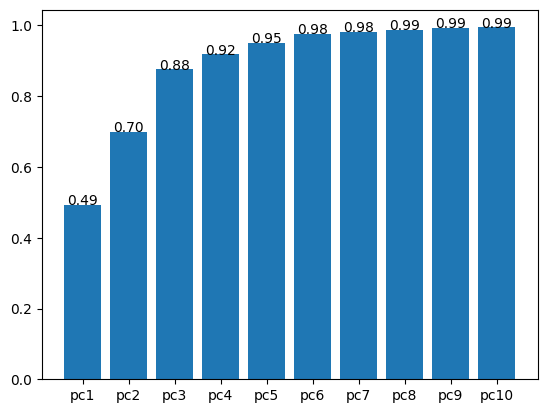

In [33]:
n_components = 10
pca = PCA(n_components=n_components).fit(data_scaled)

var_ratios_cum = np.tri(n_components) @ pca.explained_variance_ratio_
labels = [f"pc{i}" for i in range(1, n_components+1)]

plt.bar(labels, var_ratios_cum)
for i in range(n_components):
    plt.text(i, var_ratios_cum[i], f"{var_ratios_cum[i]:.2f}", ha='center')
# plt.bar(labels, pca.explained_variance_ratio_)

5 principal components capture 90% of the variance, while adding any additional components captures at most ~1%.

In [34]:
n_components = 5
pca = PCA(n_components=n_components).fit(data_scaled)

data_pca = pca.transform(data_scaled)
data_pca

array([[-5.37205535e-01,  1.97571695e-02, -2.29317072e-01,
        -1.92749334e-01, -1.16058310e-02],
       [-7.41623840e-01, -2.74345247e+00,  9.26241413e-01,
         6.29249820e-01,  3.13232729e-02],
       [-5.43898690e-01, -3.08483575e-02, -2.09890284e-01,
        -2.23510019e-01, -5.51170502e-02],
       ...,
       [-6.88318137e-01,  1.18368536e+00,  2.72249078e+00,
        -2.46052607e-01,  1.12818689e-01],
       [-6.81714157e-01,  1.26666005e+00,  2.58932629e+00,
        -1.60860618e-01,  2.19503447e-02],
       [-6.84170577e-01,  1.25723002e+00,  2.58243774e+00,
        -1.09561864e-03,  1.34035345e-01]], shape=(6436, 5))

**Nevertheless, we will evaluate each clustering model with different number of principal components**

## Clustering

For clustering, we will evaluate three separate models:

1. `KMeans`
2. `DBSCAN`
3. `GaussianMixture` (Gaussian Mixture Models, or GMMs)

For each model, a variety of different PCA datasets and hyperparameters will be tried, and the resulting clusters and cluster labels will be tested against our validation set and each other.

Prepare the collection of the evaluation data

In [35]:
# Ensure that the validation genre labels map correctly
song_genre = validation_df.loc[:, ['song_id', 'genre_id']].drop_duplicates()
song_genre = pd.merge(pd.DataFrame(data_scaled.index), song_genre, on='song_id')

RANDOM_STATE = 42

poss_principal_components = range(3, 6)

# model_metrics_columns = [ 
#     "model",
#     "hyperparameters",
#     "n_components",
#     "inertia",
#     "silhouette_score",
#     "homogeneity_score",
#     "completeness_score",    
# ]

Generate each pca datasets

In [36]:
pca_datasets = []
for n_components in poss_principal_components:
    pca_dataset = PCA(
            n_components=n_components
        ).fit_transform(data_scaled)
    pca_datasets.append(pca_dataset)

### Clustering with `KMeans`

In [37]:
max_clusters = validation_df.genre_id.max() + 1
# From .5 - 1.5 times the number of genres: super-genres and sub-genres
poss_clusters = range(8, max_clusters+9)

model_metrics = [[]] * len(pca_datasets) * len(poss_clusters)
row_index = 0


for n_components, pca_dataset in zip(poss_principal_components, pca_datasets):
    inertia = []
    silhouette = []
    
    for n_clusters in poss_clusters:
        kmeans = KMeans(
            n_clusters=n_clusters,
            random_state=RANDOM_STATE
        ).fit(pca_dataset)   
            
        # Store the cluster labeling by each model
        model_name = "kmeans"
        model_id = f"{model_name}_nclusters={n_clusters}_ncomponents={n_components}"
        song_genre.loc[:, model_id] = kmeans.labels_
        
        # Evaluation
        model_metrics[row_index] = [
            model_name,
            n_clusters, # hyperparameter
            n_components,
            kmeans.inertia_,
            silhouette_score(data_pca, kmeans.labels_),
            homogeneity_score(song_genre.genre_id, kmeans.labels_),
            completeness_score(song_genre.genre_id, kmeans.labels_)
        ]
        row_index += 1

Store evaluation metrics

In [38]:
columns = [ 
    "model",
    "clusters",
    "n_components",
    "inertia",
    "silhouette_score",
    "homogeneity_score",
    "completeness_score",    
]
kmeans_eval_df = pd.DataFrame(model_metrics, columns=columns)
kmeans_eval_df.head()

,model,clusters,n_components,inertia,silhouette_score,homogeneity_score,completeness_score
0,kmeans,8,3,152.201131,0.403785,0.047424,0.054122
1,kmeans,9,3,125.794225,0.404442,0.047651,0.054295
2,kmeans,10,3,112.424552,0.379433,0.049203,0.053885
3,kmeans,11,3,88.950596,0.308175,0.049581,0.046696
4,kmeans,12,3,78.174989,0.257738,0.052185,0.044578


#### Evaluations

Evaluate how the number of principal components affects the performance of the `KMeans` algorithm

In [39]:
metrics = ['inertia', 'silhouette_score', 'homogeneity_score', 'completeness_score']

Text(0.5, 0.98, 'Evaluation Metric Score by Number of Principal Components')

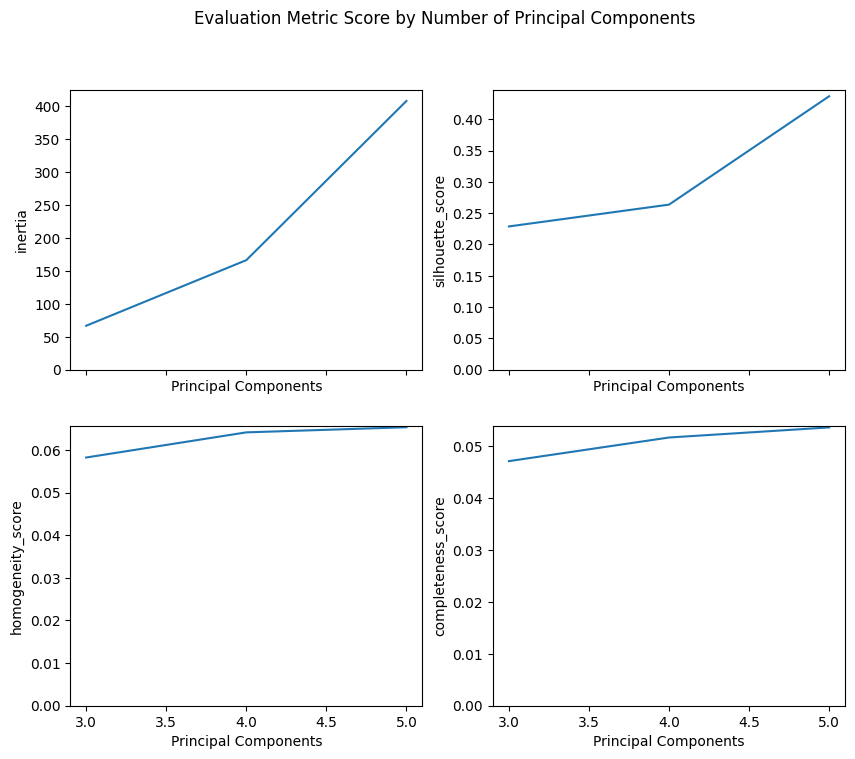

In [40]:
# Average performance by principal components
perf_by_components = kmeans_eval_df.loc[:, ['n_components'] + metrics].groupby('n_components').mean()

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,8), sharex=True)
x = perf_by_components.index
iteration = 0

for i in range(2):
    for j in range(2):
        # Access current axis
        ax = axs[i, j]
        
        # Assign current metric
        metric = metrics[iteration]
        
        # Plot data inside each chart        
        y = perf_by_components.loc[:, metric]        
        ax.plot(x, y)
        
        # Update figure axes and labels       
        ax.set_ylim(0)
        ax.set_ylabel(metric)
        ax.set_xlabel("Principal Components")
        
        
        iteration += 1

fig.suptitle("Evaluation Metric Score by Number of Principal Components")

Evaluate the effect of the number of clusters on performance

Text(0.5, 0.98, 'Evaluation Metric Score by Number of Clusters')

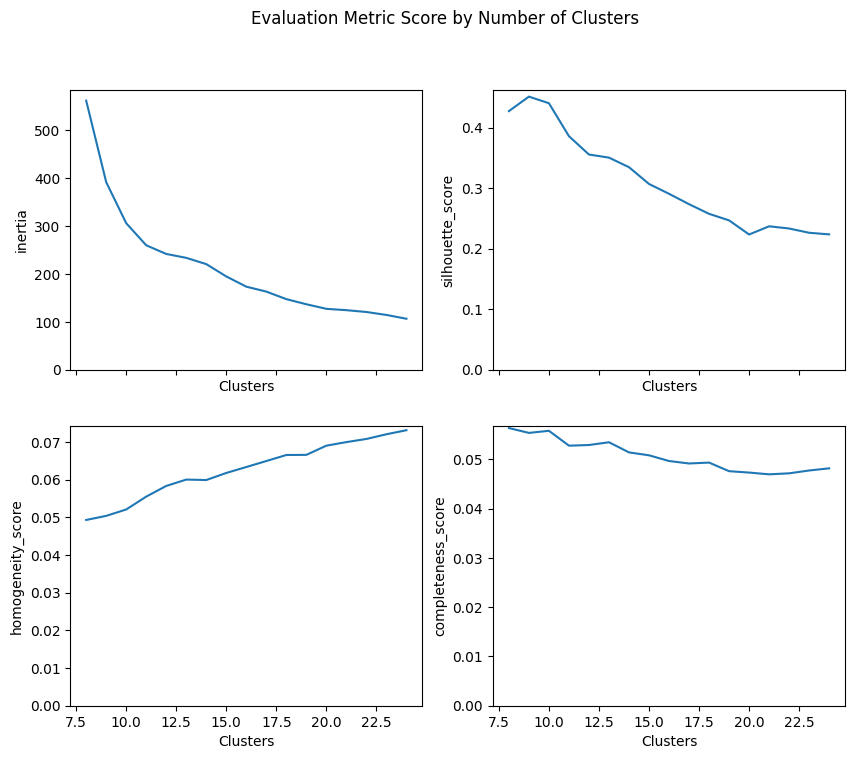

In [41]:
# Average performance by principal components
perf_by_cluster = kmeans_eval_df.loc[:, ['clusters'] + metrics].groupby('clusters').mean()

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,8), sharex=True)
x = perf_by_cluster.index
iteration = 0

for i in range(2):
    for j in range(2):
        # Access current axis
        ax = axs[i, j]
        
        # Assign current metric
        metric = metrics[iteration]
        
        # Plot data inside each chart        
        y = perf_by_cluster.loc[:, metric]        
        ax.plot(x, y)
        
        # Update figure axes and labels       
        ax.set_ylim(0)
        ax.set_ylabel(metric)
        ax.set_xlabel("Clusters")
        
        
        iteration += 1

fig.suptitle("Evaluation Metric Score by Number of Clusters")

Evaluate how the number of clusters and number of components affect performance

Text(0.5, 0.98, 'Evaluation Metric Score by Number of Principal Components & Clusters')

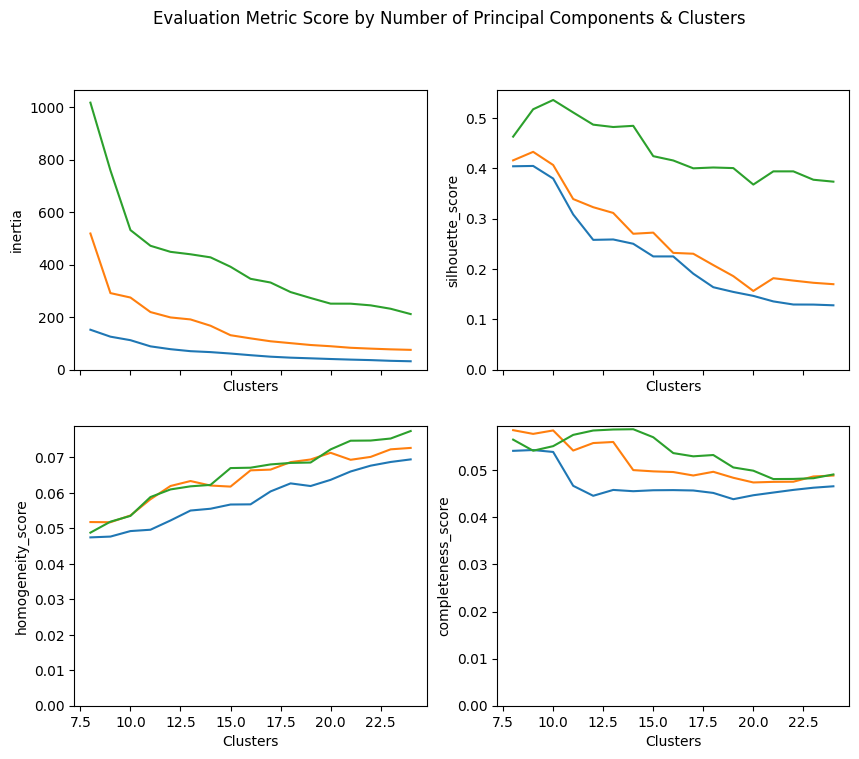

In [42]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,8), sharex=True)
x = kmeans_eval_df.clusters.unique()
iteration = 0

for i in range(2):
    for j in range(2):
        # Access current axis
        ax = axs[i, j]
        
        # Assign current metric
        metric = metrics[iteration]
        
        # Plot data inside each chart
        for n_components in kmeans_eval_df.loc[:, 'n_components'].unique():
            y = kmeans_eval_df.loc[kmeans_eval_df.loc[:, 'n_components'] == n_components, metric]
            ax.plot(x, y, label=f"{n_components} Principal Components")
        
        # Update figure axes and labels       
        ax.set_ylim(0)
        ax.set_ylabel(metric)
        ax.set_xlabel('Clusters')
        
        iteration += 1

fig.suptitle("Evaluation Metric Score by Number of Principal Components & Clusters")

### Clustering with `DBSCAN`

In [43]:
eps_list = np.arange(.25, .875, .125)
min_samples_list = range(1, 10, 2)

model_metrics = [[]] * len(poss_principal_components) * len(eps_list) * len(min_samples_list)
# print(len(model_metrics))
row_index = 0

for n_components, pca_dataset in zip(poss_principal_components, pca_datasets):
    for eps in eps_list:
        for min_samples in min_samples_list:
            dbscan = DBSCAN(
                eps=np.round(eps, 1), # .3 in eps_list was returned with a floating point error
                min_samples=min_samples,
                n_jobs=-1
            ).fit(pca_dataset)            
            
            # Store the cluster labeling by each model
            model_name = "dbscan"
            model_id = f"{model_name}_eps={eps}_minsamples={min_samples}_ncomponents={n_components}"
            song_genre.loc[:, model_id] = dbscan.labels_
            
            # Generate 1 metrics row per model
            model_metrics[row_index] = [
                model_name,
                eps, # hyperparameters
                min_samples, # hyperparameters
                n_components,
                silhouette_score(data_pca, dbscan.labels_),
                homogeneity_score(song_genre.genre_id, dbscan.labels_),
                completeness_score(song_genre.genre_id, dbscan.labels_)
            ]
            
            row_index += 1

C:\Users\chris\AppData\Local\Temp\ipykernel_4804\1208243362.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  song_genre.loc[:, model_id] = dbscan.labels_
C:\Users\chris\AppData\Local\Temp\ipykernel_4804\1208243362.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  song_genre.loc[:, model_id] = dbscan.labels_
C:\Users\chris\AppData\Local\Temp\ipykernel_4804\1208243362.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Cons

Store evaluation metrics

In [44]:
columns = [ 
    "model",
    "eps",
    "min_samples",
    "n_components",
    "silhouette_score",
    "homogeneity_score",
    "completeness_score",    
]
dbscan_eval_df = pd.DataFrame(model_metrics, columns=columns)
dbscan_eval_df.head()

,model,eps,min_samples,n_components,silhouette_score,homogeneity_score,completeness_score
0,dbscan,0.25,1,3,0.573011,0.032472,0.060368
1,dbscan,0.25,3,3,0.833102,0.031046,0.057944
2,dbscan,0.25,5,3,0.833102,0.031046,0.057944
3,dbscan,0.25,7,3,0.832279,0.030893,0.057632
4,dbscan,0.25,9,3,0.831716,0.030898,0.057629


#### Evaluations

In [45]:
metrics = ['silhouette_score', 'homogeneity_score', 'completeness_score']

##### Evaluating one hyperparameter at a time

Evaluate effect of the number of principal components on the model

Text(0.5, 0.98, 'DBSCAN Evaluation Metric Score by Number of Principal Components')

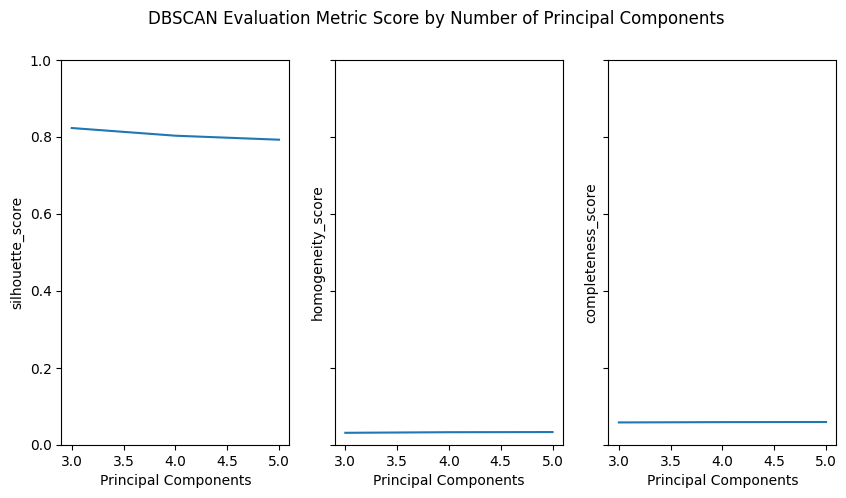

In [46]:
# Average performance by principal components
perf_by_components = dbscan_eval_df.loc[:, ['n_components'] + metrics].groupby('n_components').mean()

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10,5), sharex=True, sharey=True)
x = perf_by_components.index

for i in range(3):
    # Access current axis
    ax = axs[i]
    
    # Assign current metric
    metric = metrics[i]
    
    # Plot data inside each chart        
    y = perf_by_components.loc[:, metric]        
    ax.plot(x, y)
    
    # Update figure axes and labels       
    ax.set_ylim(0, 1)
    ax.set_ylabel(metric)
    ax.set_xlabel("Principal Components")

fig.suptitle(f"{model_name.upper()} Evaluation Metric Score by Number of Principal Components")

Evaluate the effect of eps on model performance

Text(0.5, 0.98, 'DBSCAN Evaluation Metric Score by eps Value')

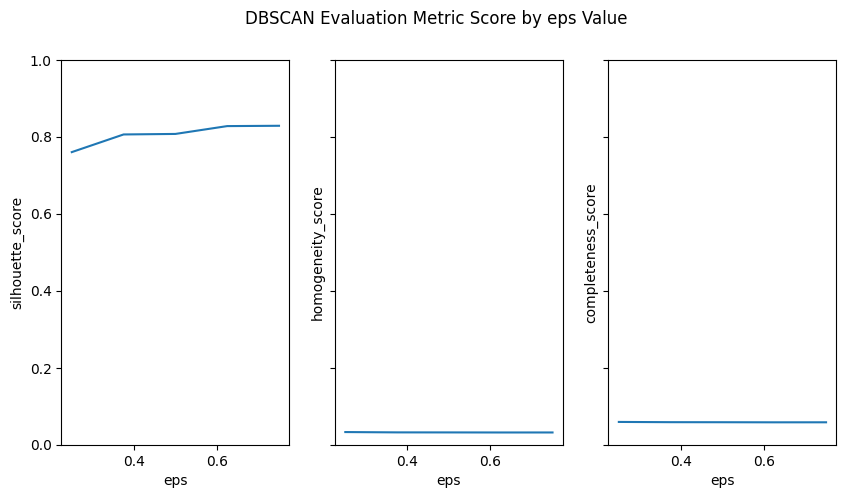

In [47]:
# Average performance by principal components
perf_by_components = dbscan_eval_df.loc[:, ['eps'] + metrics].groupby('eps').mean()

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10,5), sharex=True, sharey=True)
x = perf_by_components.index

for i in range(3):
    # Access current axis
    ax = axs[i]
    
    # Assign current metric
    metric = metrics[i]
    
    # Plot data inside each chart        
    y = perf_by_components.loc[:, metric]        
    ax.plot(x, y)
    
    # Update figure axes and labels       
    ax.set_ylim(0, 1)
    ax.set_ylabel(metric)
    ax.set_xlabel("eps")

fig.suptitle(f"{model_name.upper()} Evaluation Metric Score by eps Value")

Evaluate the effect of `min_samples` on model performance

Text(0.5, 0.98, 'DBSCAN Evaluation Metric Score by Number of Min Samples')

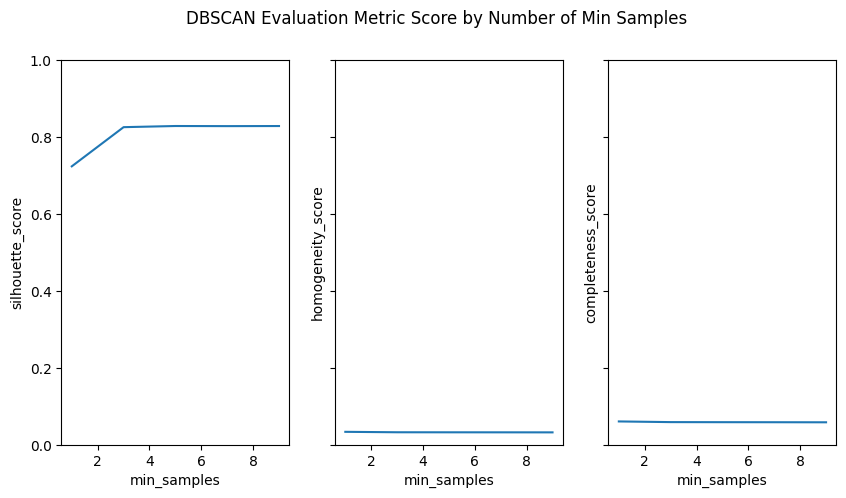

In [48]:
# Average performance by principal components
perf_by_components = dbscan_eval_df.loc[:, ['min_samples'] + metrics].groupby('min_samples').mean()

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10,5), sharex=True, sharey=True)
x = perf_by_components.index

for i in range(3):
    # Access current axis
    ax = axs[i]
    
    # Assign current metric
    metric = metrics[i]
    
    # Plot data inside each chart        
    y = perf_by_components.loc[:, metric]        
    ax.plot(x, y)
    
    # Update figure axes and labels       
    ax.set_ylim(0, 1)
    ax.set_ylabel(metric)
    ax.set_xlabel("min_samples")

fig.suptitle(f"{model_name.upper()} Evaluation Metric Score by Number of Min Samples")

##### Evaluating two hyperparameters at a time

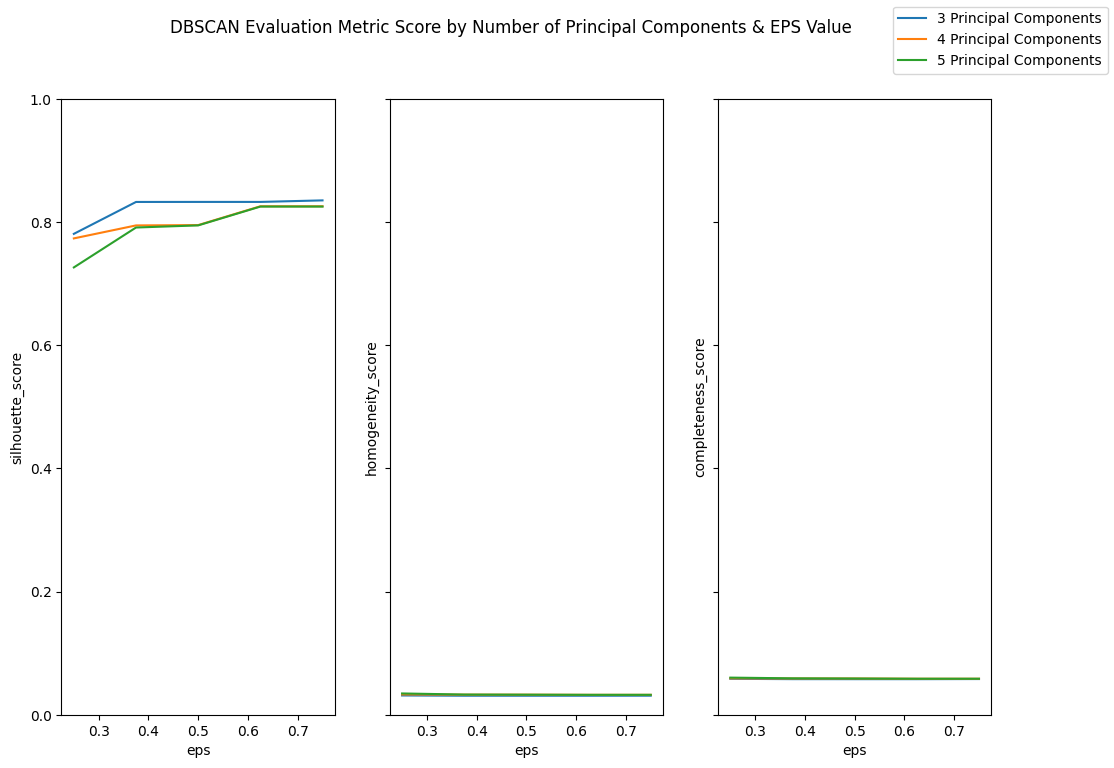

In [49]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,8), sharex=True, sharey=True)
x = dbscan_eval_df.eps.unique()
hyperparameter = 'eps'

for i in range(3):
    # Access current axis
    ax = axs[i]
    
    # Assign current metric
    metric = metrics[i]
    
    # Plot data inside each chart
    for n_components in dbscan_eval_df.loc[:, 'n_components'].unique():
        y = dbscan_eval_df.loc[dbscan_eval_df.loc[:, 'n_components'] == n_components, [hyperparameter, metric]].groupby(hyperparameter).mean()
        ax.plot(x, y, label=f"{n_components} Principal Components" if i == 2 else "")
    
    # Update figure axes and labels       
    ax.set_ylim(0, 1)
    ax.set_ylabel(metric)
    ax.set_xlabel('eps')

fig.suptitle(f"{model_name.upper()} Evaluation Metric Score by Number of Principal Components & EPS Value")
fig.legend()

Evaluate the effect of `min_samples` and the number of principal components on model performance

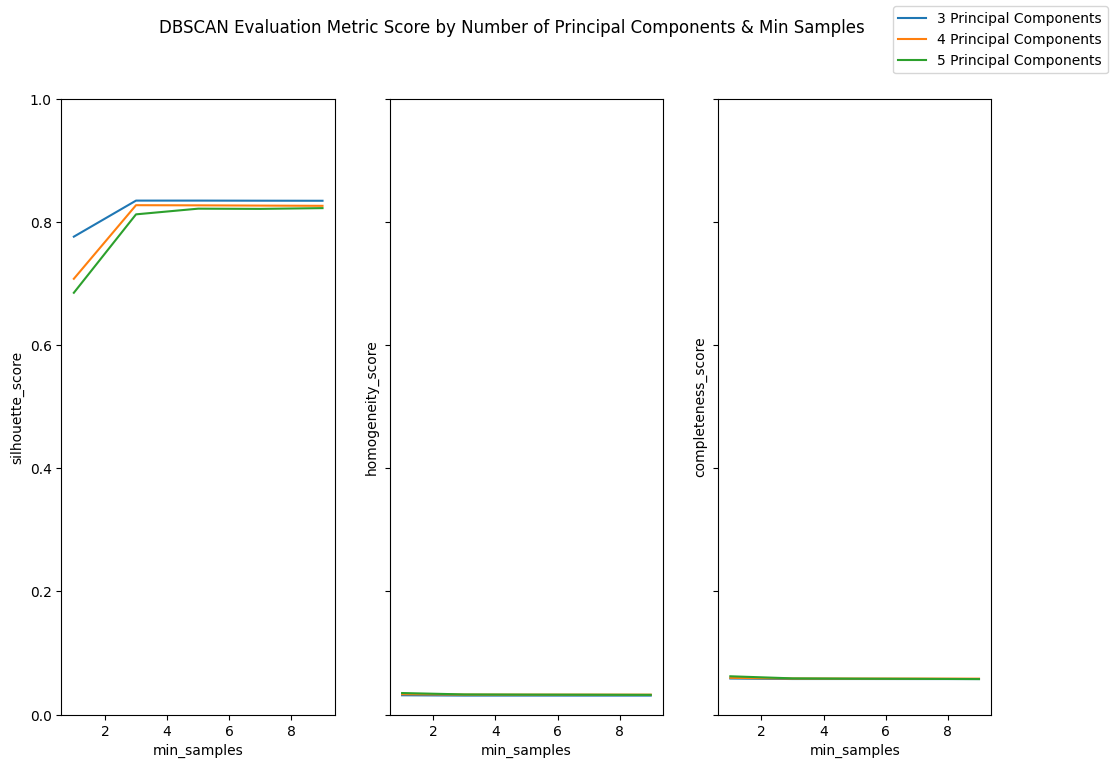

In [50]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,8), sharex=True, sharey=True)
x = dbscan_eval_df.min_samples.unique()
hyperparameter = 'min_samples'

for i in range(3):
    # Access current axis
    ax = axs[i]
    
    # Assign current metric
    metric = metrics[i]
    
    # Plot data inside each chart
    for n_components in dbscan_eval_df.loc[:, 'n_components'].unique():
        y = dbscan_eval_df.loc[dbscan_eval_df.loc[:, 'n_components'] == n_components, [hyperparameter, metric]].groupby(hyperparameter).mean()
        ax.plot(x, y, label=f"{n_components} Principal Components" if i == 2 else "") # Only add labels to the legend in final loop to avoid duplicates
    
    # Update figure axes and labels       
    ax.set_ylim(0, 1)
    ax.set_ylabel(metric)
    ax.set_xlabel('min_samples')

fig.suptitle(f"{model_name.upper()} Evaluation Metric Score by Number of Principal Components & Min Samples")
fig.legend()

Evaluate the effect of `min_samples` and `eps` on model performance

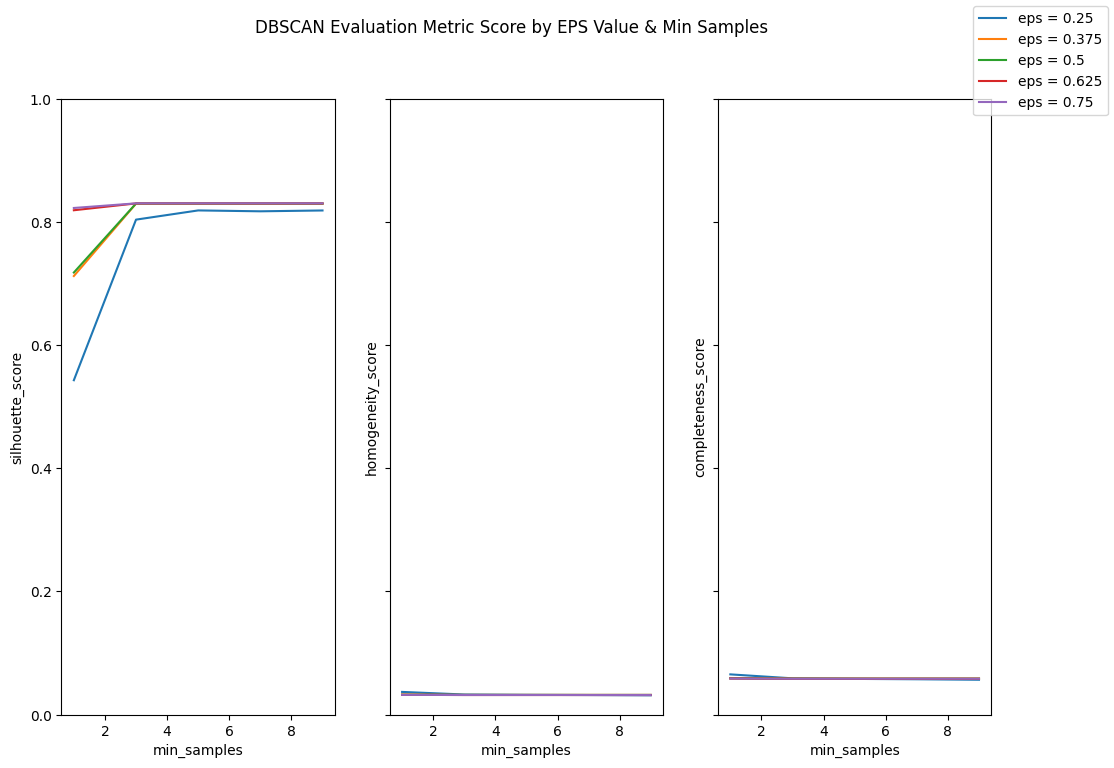

In [51]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,8), sharex=True, sharey=True)
x = dbscan_eval_df.min_samples.unique()
hyperparameter = 'min_samples'

for i in range(3):
    # Access current axis
    ax = axs[i]
    
    # Assign current metric
    metric = metrics[i]
    
    # Plot data inside each chart
    for eps in dbscan_eval_df.loc[:, 'eps'].unique():
        y = dbscan_eval_df.loc[dbscan_eval_df.loc[:, 'eps'] == eps, [hyperparameter, metric]].groupby(hyperparameter).mean()
        ax.plot(x, y, label=f"eps = {eps}" if i == 2 else "") # Only add labels to the legend in final loop to avoid duplicates
    
    # Update figure axes and labels       
    ax.set_ylim(0, 1)
    ax.set_ylabel(metric)
    ax.set_xlabel('min_samples')

fig.suptitle(f"{model_name.upper()} Evaluation Metric Score by EPS Value & Min Samples")
fig.legend()

### Clustering with `GaussianMixture`

In [52]:
n_mixture_components = range(1,6)
covariance_types = ['full', 'tied', 'diag', 'spherical']

model_metrics = [[]] * len(pca_datasets) * len(n_mixture_components) * len(covariance_types)
row_index = 0

gmm_models_skipped = []

for n_components, pca_dataset in zip(poss_principal_components, pca_datasets):
    for covariance_type in covariance_types:
        for mixture_components in n_mixture_components:
            gmm = GaussianMixture(
                n_components=mixture_components,
                covariance_type=covariance_type,
                random_state=RANDOM_STATE
            ).fit(pca_dataset)   
                
            # Store the cluster labeling by each model
            model_name = "gmm"
            model_id = f"{model_name}_covariancetype={covariance_type}_mixturecomponents={mixture_components}_ncomponents={n_components}"
            labels = gmm.predict(pca_dataset)
            
            # Some models only assign data to 1 cluster, which throws an error for the silhouette_score
            if len(set(labels)) == 1:
                gmm_models_skipped.append(model_id)
                continue
            
            song_genre.loc[:, model_id] = labels
            
            # Evaluation
            model_metrics[row_index] = [
                model_name,
                covariance_type, # hyperparameter
                mixture_components, # hyperparameter
                n_components,
                silhouette_score(data_pca, labels),
                homogeneity_score(song_genre.genre_id, labels),
                completeness_score(song_genre.genre_id, labels)
            ]
            row_index += 1

print(f"{len(gmm_models_skipped)} out of {len(model_metrics)} models were skipped:")
print(gmm_models_skipped)

model_metrics = [full_row for full_row in model_metrics if len(full_row) > 0]

C:\Users\chris\AppData\Local\Temp\ipykernel_4804\2359642359.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  song_genre.loc[:, model_id] = labels
C:\Users\chris\AppData\Local\Temp\ipykernel_4804\2359642359.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  song_genre.loc[:, model_id] = labels
C:\Users\chris\AppData\Local\Temp\ipykernel_4804\2359642359.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all

12 out of 60 models were skipped:
['gmm_covariancetype=full_mixturecomponents=1_ncomponents=3', 'gmm_covariancetype=tied_mixturecomponents=1_ncomponents=3', 'gmm_covariancetype=diag_mixturecomponents=1_ncomponents=3', 'gmm_covariancetype=spherical_mixturecomponents=1_ncomponents=3', 'gmm_covariancetype=full_mixturecomponents=1_ncomponents=4', 'gmm_covariancetype=tied_mixturecomponents=1_ncomponents=4', 'gmm_covariancetype=diag_mixturecomponents=1_ncomponents=4', 'gmm_covariancetype=spherical_mixturecomponents=1_ncomponents=4', 'gmm_covariancetype=full_mixturecomponents=1_ncomponents=5', 'gmm_covariancetype=tied_mixturecomponents=1_ncomponents=5', 'gmm_covariancetype=diag_mixturecomponents=1_ncomponents=5', 'gmm_covariancetype=spherical_mixturecomponents=1_ncomponents=5']


Store evaluation metrics

In [53]:
columns = [ 
    "model",
    "covariance_type",
    "mixture_components",
    "n_components",
    "silhouette_score",
    "homogeneity_score",
    "completeness_score",    
]
gmm_eval_df = pd.DataFrame(model_metrics, columns=columns)
gmm_eval_df.head()

,model,covariance_type,mixture_components,n_components,silhouette_score,homogeneity_score,completeness_score
0,gmm,full,2,3,0.692077,0.011501,0.042217
1,gmm,full,3,3,0.756918,0.020724,0.052379
2,gmm,full,4,3,0.820454,0.024908,0.048705
3,gmm,full,5,3,0.828410,0.029625,0.056755
4,gmm,tied,2,3,0.692077,0.011501,0.042217


#### Evaluations

In [54]:
metrics = ['silhouette_score', 'homogeneity_score', 'completeness_score']

##### Functions

In [55]:
def plot_subplots(grouped_df, metrics, title, xlabel, ylim_bounds=(0,1), ncols=3, figsize=(10,5), sharex=True, sharey=True, bar=False):
    fig, axs = plt.subplots(nrows=1, ncols=ncols, figsize=figsize,
                            sharex=sharex, sharey=sharey)
    
    x_data = grouped_df.index
    
    for i in range(ncols):
        # Access current axis
        ax = axs[i]
        
        # Assign current metric
        metric = metrics[i]
        
        # Plot data inside each chart        
        y_data = grouped_df.loc[:, metric]
        if bar:
            ax.bar(x_data, y_data)
        else:
            ax.plot(x_data, y_data)
        
        # Update figure axes and labels       
        ax.set_ylim(ylim_bounds)
        ax.set_ylabel(metric)
        ax.set_xlabel(xlabel)

    fig.suptitle(title)

In [56]:
def plot_subplots_2hparams(grouped_df, hparam1, hparam2, metrics, title,
                           xlabel, ylim_bounds=(0,1), ncols=3, figsize=(10,5),
                           sharex=True, sharey=True, bar=False):
    
    fig, axs = plt.subplots(nrows=1, ncols=ncols, figsize=figsize,
                            sharex=sharex, sharey=sharey)
    
    x_data = grouped_df.loc[:, hparam1].unique()
    
    
    for i in range(ncols):
        # Access current axis
        ax = axs[i]
        
        # Assign current metric
        metric = metrics[i]
                
        # Plot data inside each chart        
        y_data = grouped_df.loc[:, metric]
        # Plot data inside each chart
        for j, hparam2_val in enumerate(grouped_df.loc[:, hparam2].unique()):
            agg = grouped_df.loc[grouped_df.loc[:, hparam2] == hparam2_val, [hparam1, metric]].groupby(hparam1).mean()
            y_data = agg.loc[:, metric]
            
            if bar:
                pass
            else:
                ax.plot(x_data, y_data, label=f"{hparam2_val} {hparam2}" if i == 2 else "")
        
        # Update figure axes and labels       
        ax.set_ylim(ylim_bounds)
        ax.set_ylabel(metric)
        ax.set_xlabel(xlabel)

    fig.suptitle(title)
    fig.legend()

##### Evaluating one hyperparameter at a time

Model performance by number of principal components

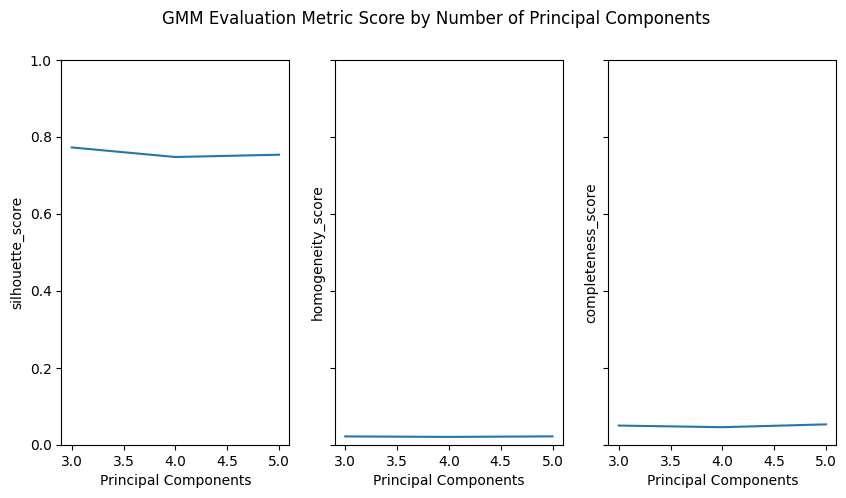

In [57]:
hyperparameter = ['n_components']

# Average performance by principal components
perf_by_components = gmm_eval_df.loc[:, hyperparameter + metrics].groupby(hyperparameter).mean()

plot_subplots(
    grouped_df=perf_by_components,
    metrics=metrics,
    title=f"{model_name.upper()} Evaluation Metric Score by Number of Principal Components",
    xlabel="Principal Components"
)

Performance by number of mixture components

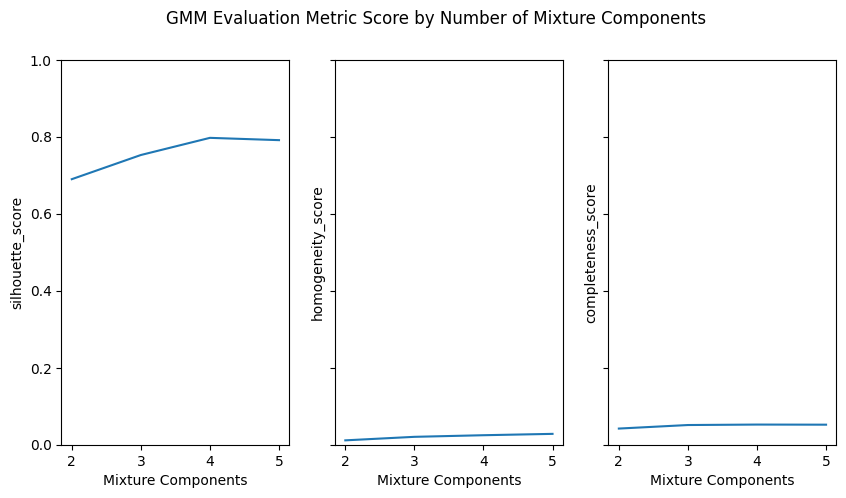

In [58]:
hyperparameter = ['mixture_components']

# Average performance by principal components
perf_by_components = gmm_eval_df.loc[:, hyperparameter + metrics].groupby(hyperparameter).mean()

plot_subplots(
    grouped_df=perf_by_components,
    metrics=metrics,
    title=f"{model_name.upper()} Evaluation Metric Score by Number of Mixture Components",
    xlabel="Mixture Components"
)

Performance by covariance type

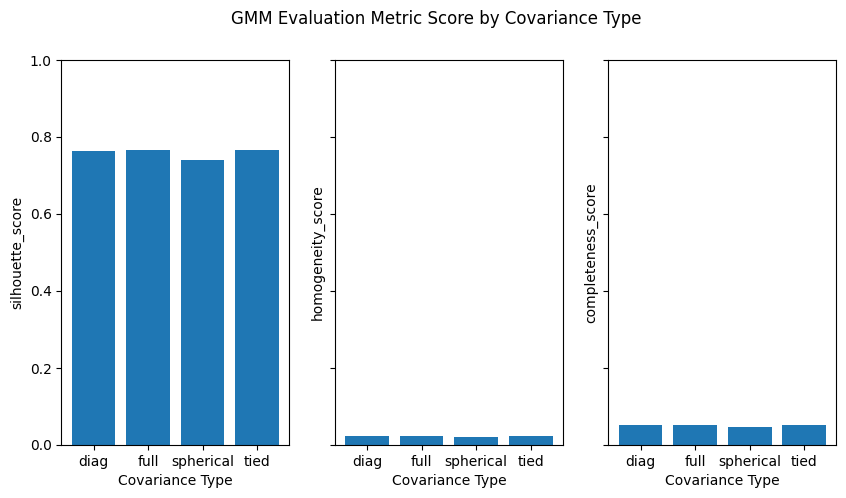

In [59]:
hyperparameter = ['covariance_type']

# Average performance by principal components
perf_by_components = gmm_eval_df.loc[:, hyperparameter + metrics].groupby(hyperparameter).mean()

plot_subplots(
    grouped_df=perf_by_components,
    metrics=metrics,
    title=f"{model_name.upper()} Evaluation Metric Score by Covariance Type",
    xlabel="Covariance Type",
    bar=True
)

##### Evaluating two hyperparameters at a time

by number of principal components and mixture components

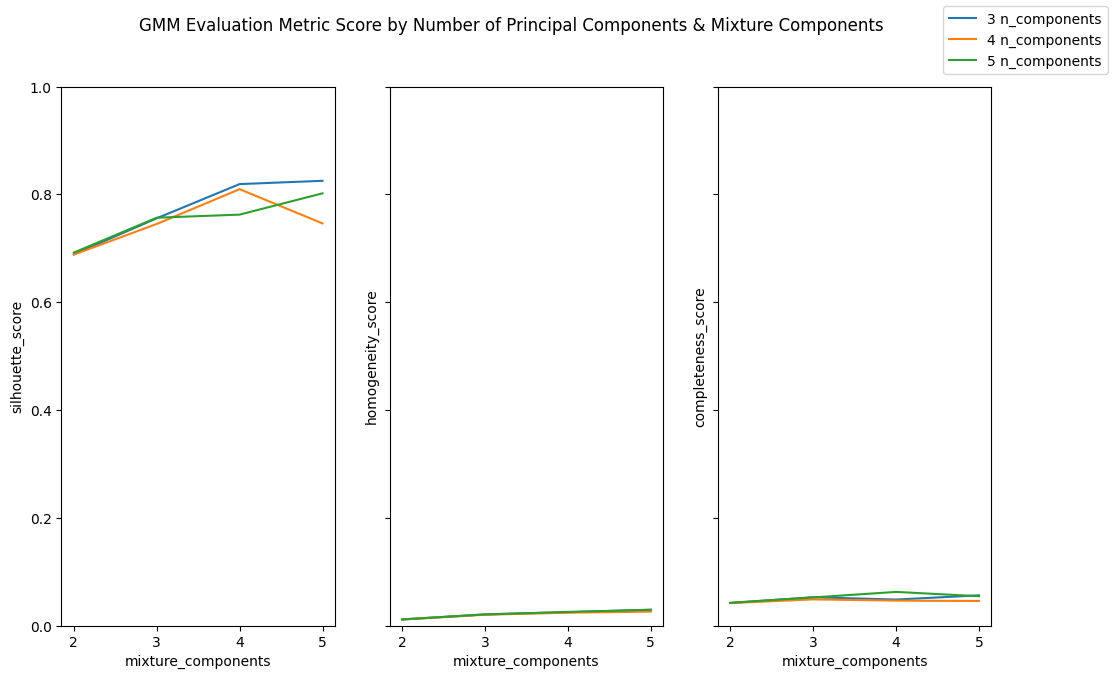

In [60]:
plot_subplots_2hparams(
    grouped_df=gmm_eval_df,
    hparam1='mixture_components',
    hparam2='n_components',
    metrics=metrics,
    title=f"{model_name.upper()} Evaluation Metric Score by Number of Principal Components & Mixture Components",
    xlabel="mixture_components",
    figsize=(12, 7)
)

by `covariance_type` and number of mixture components

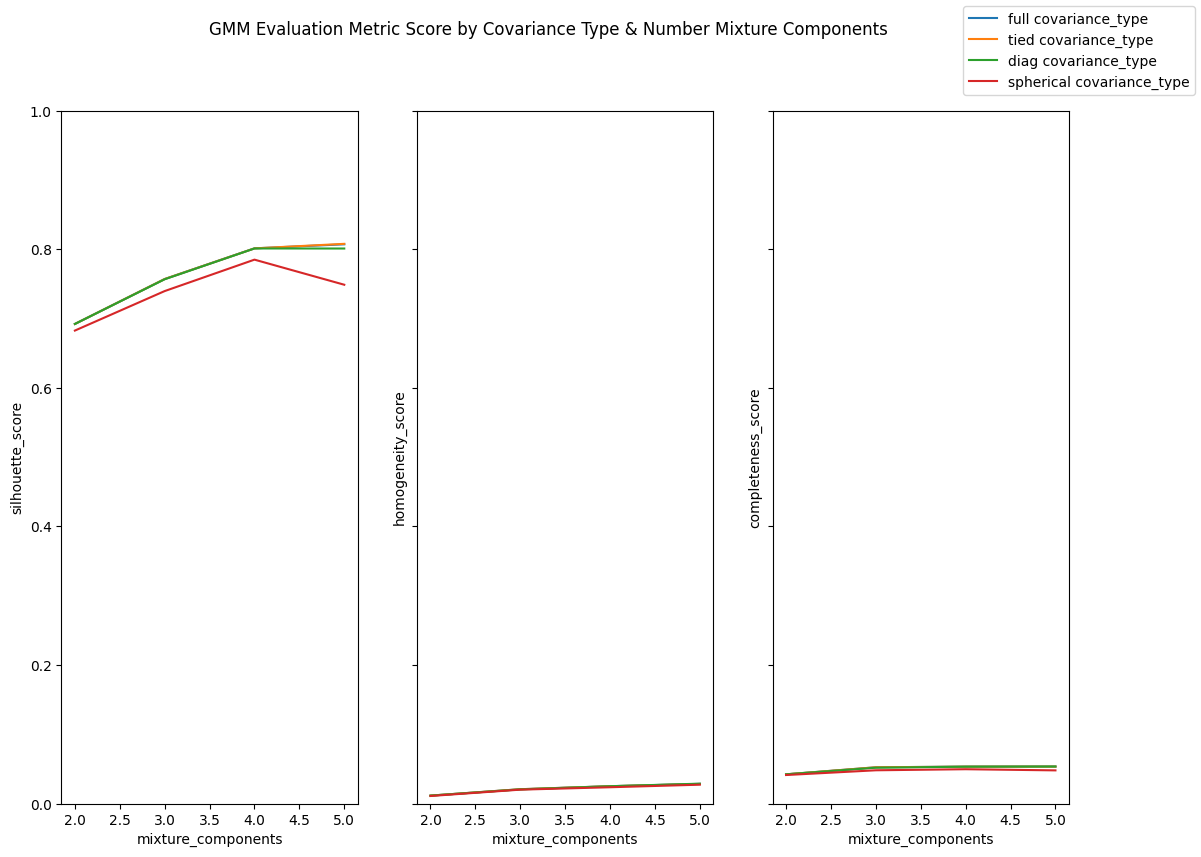

In [61]:
plot_subplots_2hparams(
    grouped_df=gmm_eval_df,
    hparam1='mixture_components',
    hparam2='covariance_type',
    metrics=metrics,
    title=f"{model_name.upper()} Evaluation Metric Score by Covariance Type & Number Mixture Components",
    xlabel="mixture_components",
    figsize=(13, 9)
)

by `covariance_type` and number of principal components

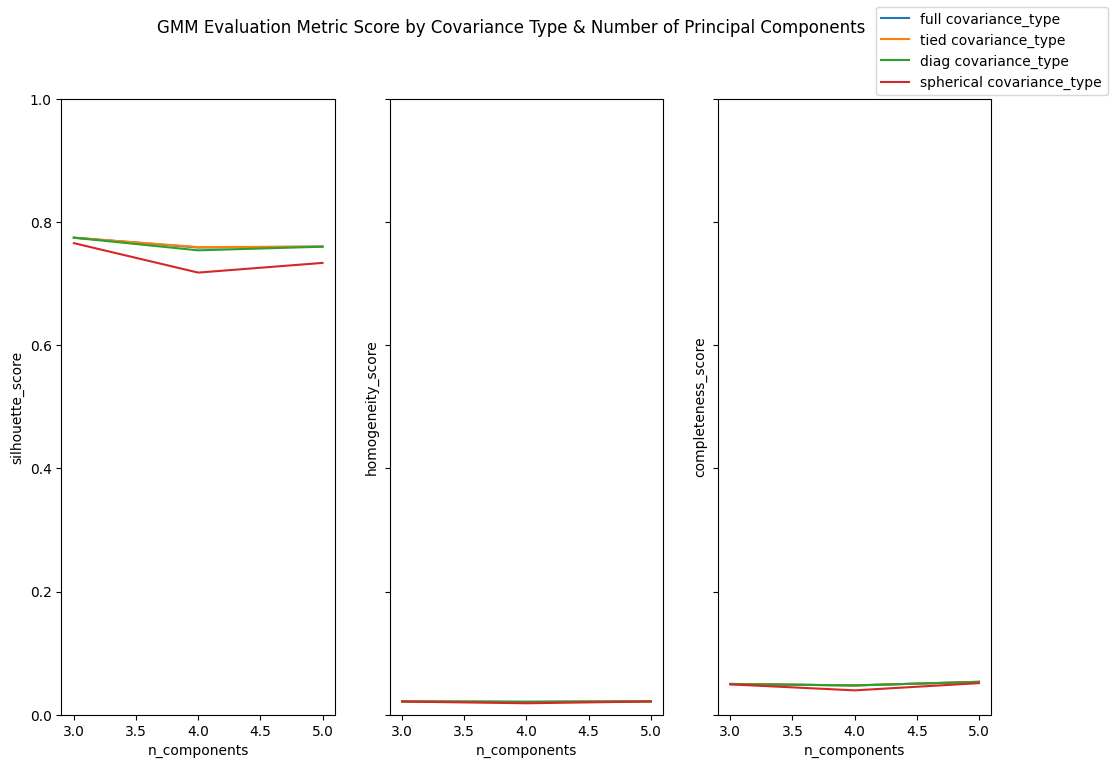

In [62]:
plot_subplots_2hparams(
    grouped_df=gmm_eval_df,
    hparam1='n_components',
    hparam2='covariance_type',
    metrics=metrics,
    title=f"{model_name.upper()} Evaluation Metric Score by Covariance Type & Number of Principal Components",
    xlabel="n_components",
    figsize=(12, 8)
)

### Cross model comparisons

When considering the number of principal components effect on model performance we found the following:

- `KMeans`: Performed better across all metrics as the number of principal components used in the training dataset increased from 3-5
- `DBSCAN`: Increasing the number of principal components slightly decreased the `silhouette_score` and had almost no effect on `homogeneity` or `completeness`
- `GaussianMixture`: Similar to `DBSCAN`, increasing the number of principal components lead to a downward trend in the `silhouette_score`, and had almost no effect on `homogeneity`. Increasing the number of components slightly improved the `completeness_score`.

Below we can visualize this more concisely.

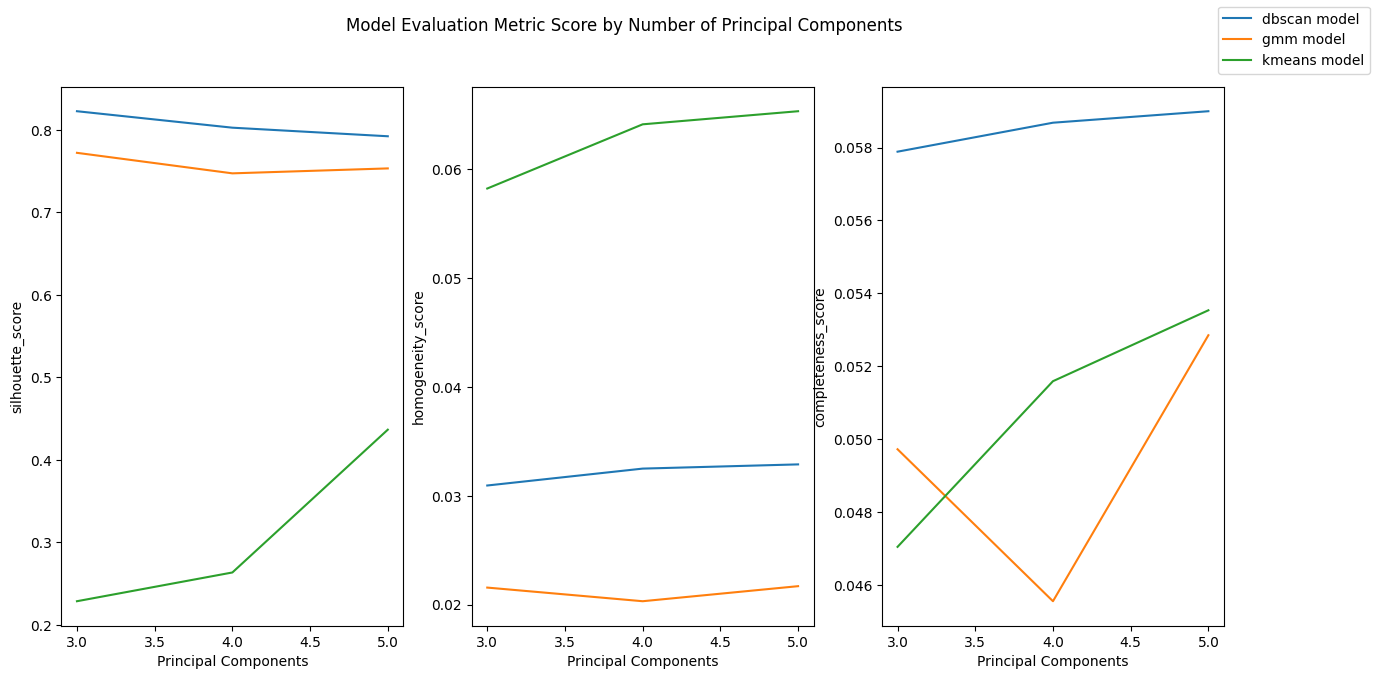

In [63]:
cols_to_keep = [
    'model',
    'n_components',
    'silhouette_score',
    'homogeneity_score',
    'completeness_score'
]

model_evaluation_dfs = [
    kmeans_eval_df.loc[:, cols_to_keep],
    dbscan_eval_df.loc[:, cols_to_keep],
    gmm_eval_df.loc[:, cols_to_keep]
]

perf_by_model_and_components_df = pd.concat(model_evaluation_dfs).groupby(['model', 'n_components']).mean().reset_index()
plot_subplots_2hparams(
    perf_by_model_and_components_df,
    hparam1='n_components',
    hparam2='model',
    metrics=metrics,
    title="Model Evaluation Metric Score by Number of Principal Components",
    xlabel="Principal Components",
    sharey=False,
    ylim_bounds=(None, None), # We want to clearly see the differences
    figsize=(15,7)
)

This view into the models' performances does not provide a clear "better" model in the aggregate - however, the `GaussianMixture` model never achieves the highest score across any metric. Although more views of the performances should be considered, it's worth noting that we might need to choose based on non-performance based criteria.

For instance, although having the actual genre labels would suggest that the `homogeneity` and `completeness` scores should be considered the most informative, it's clear that all models perform quite abysmally. This isn't too surprising as the `homogeneity` score should not be high if the maximum number of predicted clusters is less than the actual number of genres, because there *should* expect that several (if not all) predicted clusters would be comprised of multiple genres. `completeness` scores on the other hand should be low when the model produces a higher number of predictor clusters than there are distinct genres, because none of the clusters could be considered complete.

With that in mind, it would be meaningful to look at the distribution of predicted clusters for each model - note that this won't reveal any new information for `KMeans` as the number of clusters is a hyperparameter.

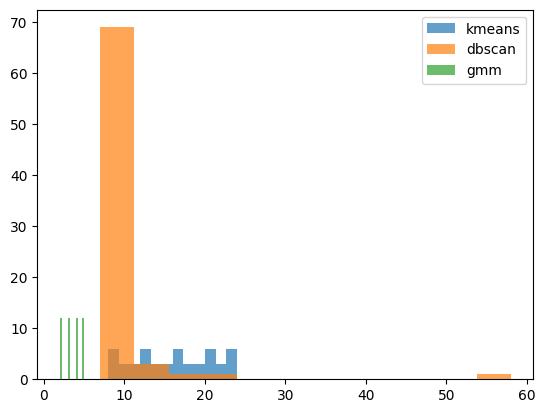

In [64]:
models = [
    'kmeans',
    'dbscan',
    'gmm'
]

cluster_counts = {
    'kmeans': [],
    'dbscan': [],
    'gmm': []
}

n_clusters_per_model = song_genre.nunique()

for model in models:
    model_cols = [col for col in song_genre.columns if model in col]
    cluster_counts[model] = n_clusters_per_model[model_cols].values.tolist()
    plt.hist(cluster_counts[model], bins=12, label=model, alpha=.7)
plt.legend();

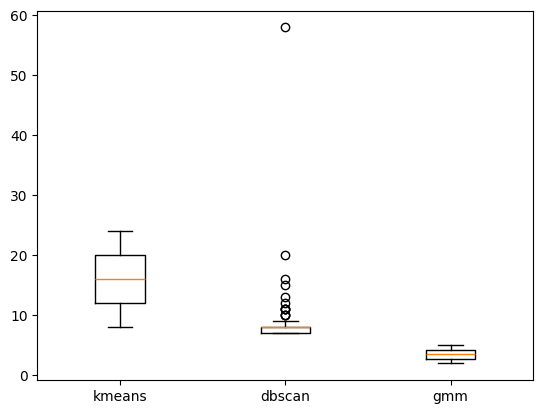

In [65]:
cluster_counts_list = [val for key, val in cluster_counts.items()]
plt.boxplot(
    cluster_counts_list,
    tick_labels=models
);

When considering `DBSCAN` and `GaussianMixture` cluster distribution, it makes more sense why `GaussianMixture` performed so poorly on the `completeness` and `homogeneity` scores. It could be worthwhile to visualize how the number of clusters affected performance to see if that could help rule out any specific models.

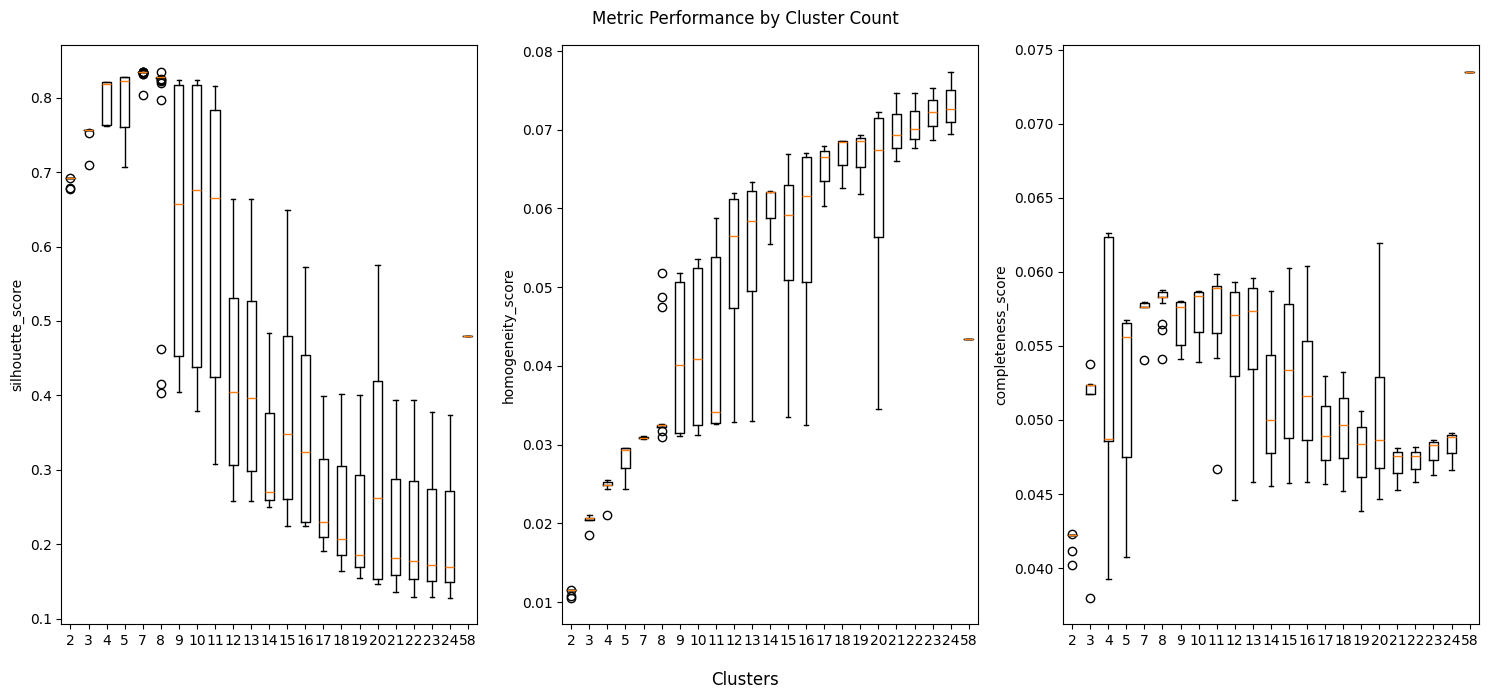

In [66]:
# Because the concatenation is occuring in the same order that the models were generated, we don't need to worry about special mapping methods
model_evaluation_df = pd.concat(model_evaluation_dfs)
model_evaluation_df.loc[:, 'n_clusters'] = n_clusters_per_model.iloc[2:].values # ignoring the song_id and genre_id columns

clusters = sorted(model_evaluation_df.n_clusters.unique())

silhouette_by_cluster = []
homogeneity_by_cluster = []
completeness_by_cluster = []

for cluster in clusters:
    silhouette_scores = model_evaluation_df.loc[model_evaluation_df.n_clusters == cluster, 'silhouette_score'].tolist()
    silhouette_by_cluster.append(silhouette_scores)
                                 
    homogeneity_scores = model_evaluation_df.loc[model_evaluation_df.n_clusters == cluster, 'homogeneity_score'].tolist()
    homogeneity_by_cluster.append(homogeneity_scores)
                                 
    completeness_scores = model_evaluation_df.loc[model_evaluation_df.n_clusters == cluster, 'completeness_score'].tolist()
    completeness_by_cluster.append(completeness_scores)
    
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,7))

by_cluster_scores = [
    silhouette_by_cluster,
    homogeneity_by_cluster,
    completeness_by_cluster
]

for i in range(3):
    ax[i].boxplot(
        by_cluster_scores[i],
        tick_labels=clusters
    )
    
    ax[i].set_ylabel(metrics[i])

fig.supxlabel("Clusters")
fig.suptitle("Metric Performance by Cluster Count")
fig.tight_layout();

This visual also shows that there isn't a clear directionality based on a single feature (i.e., number of clusters). Therefore it would be worthwhile to compare individual model performance within each metric, and across each metric.

We will start by considering a single metric at a time:

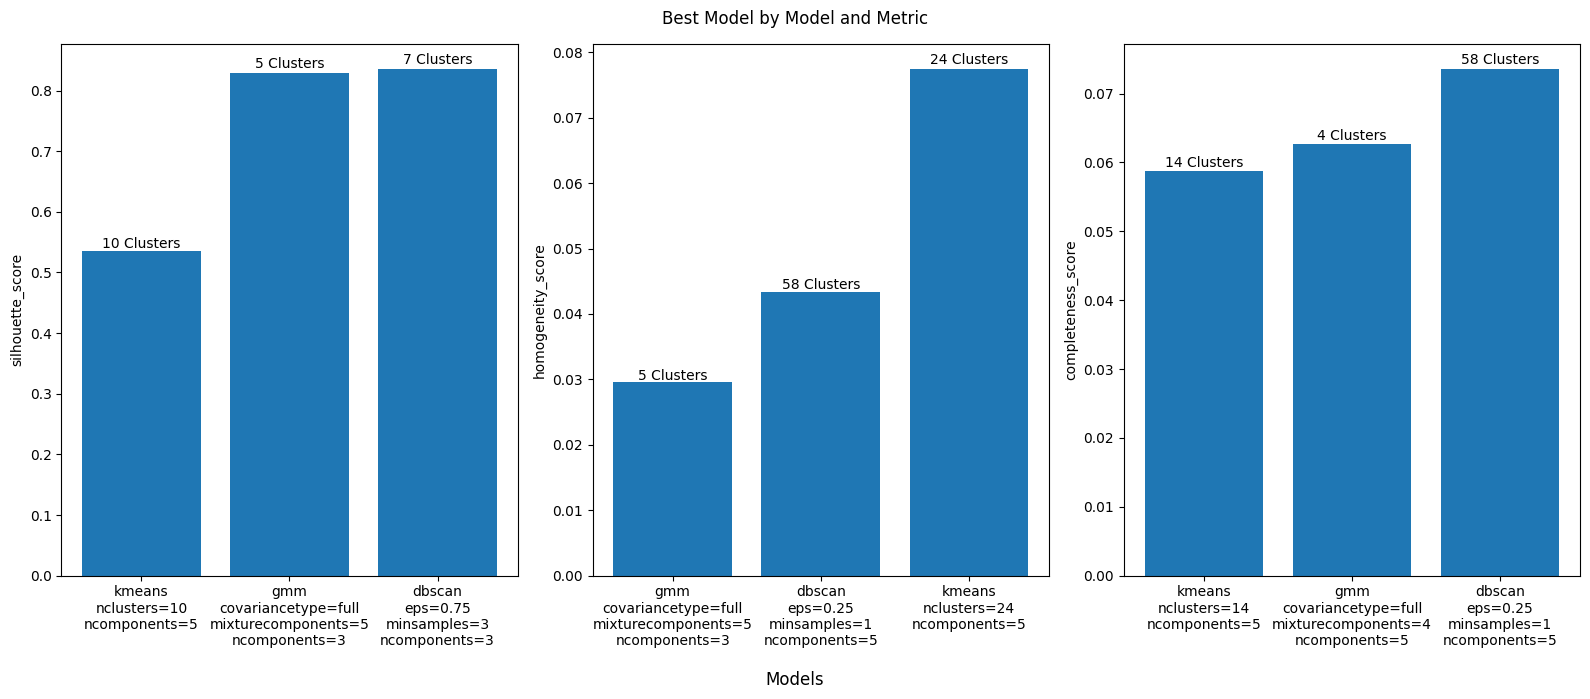

In [189]:
# best_model_by_silhouette = model_evaluation_df
# best_model_by_silhouette

model_evaluation_df.index = n_clusters_per_model.iloc[2:].index # ignoring the song_id and genre_id columns

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,7))


for i in range(3):    
    best_models = model_evaluation_df.loc[:, ['model', metrics[i], 'n_clusters']].sort_values(by=['model', metrics[i]], ascending=[True, False]).drop_duplicates(subset='model')
    best_models.reset_index(inplace=True, names='model_id')
    best_models.sort_values(by=metrics[i], inplace=True) # Ensure chart is ordered from greatest to least
    
    ax[i].bar(
        best_models.loc[:, 'model_id'].str.replace('_', '\n'),
        best_models.loc[:, metrics[i]],
        label=best_models.loc[:, 'model_id'].tolist()
    )
    
    bar_labels = [f"{n_clusters} Clusters" for n_clusters in best_models.loc[:, 'n_clusters']]
    
    rects = ax[i].patches
    
    for rect, label in zip(rects, bar_labels):
        ax[i].text(
            rect.get_x() + rect.get_width() / 2,
            1.01 * rect.get_height(),
            label,
            ha='center'
            )
    
    ax[i].set_ylabel(metrics[i])

fig.supxlabel("Models")
fig.suptitle("Best Model by Model and Metric")
fig.tight_layout();

The `DBSCAN` algorithm produces the best or second best model when considering a single metric at a time. Although homing in on a single model is a good sign, it will be important to see how this changes when considering the best model across each metric. We can do this by normalizing the metric scores within each model and metric, and then compare the average of the normalize metric scores across each model type.

In [190]:
# Use MinMaxScaler to normalize each performance metric within each model and metric type
model_evaluation_norm_dfs = []

for i, model in enumerate(models):
    df = model_evaluation_dfs[i]
    
    normalized_metrics = MinMaxScaler().fit_transform(df.loc[:, metrics])
    
    normalized_df = pd.concat(
        [
            df.loc[:, 'model'],
            pd.DataFrame(normalized_metrics, columns=metrics)
        ],
        axis=1
    )
    
    model_evaluation_norm_dfs.append(normalized_df)

model_evaluation_norm_df = pd.concat(model_evaluation_norm_dfs)
model_evaluation_norm_df

,model,silhouette_score,homogeneity_score,completeness_score
0,kmeans,0.677110,0.000000,0.690942
1,kmeans,0.678722,0.007551,0.702602
2,kmeans,0.617349,0.059352,0.675054
3,kmeans,0.442478,0.071976,0.191228
4,kmeans,0.318703,0.158892,0.048664
...,...,...,...,...
43,gmm,0.998696,0.996796,0.757016
44,gmm,0.098327,0.052367,0.175000
45,gmm,0.524784,0.535877,0.585197
46,gmm,0.562803,0.773166,0.987951


In [191]:
# Average out the scores to enable comparison across all metrics at once
model_evaluation_norm_df.loc[:, 'avg_composition'] = model_evaluation_norm_df.loc[:, metrics].sum(axis=1) / len(metrics)
model_evaluation_norm_df

,model,silhouette_score,homogeneity_score,completeness_score,avg_composition
0,kmeans,0.677110,0.000000,0.690942,0.456017
1,kmeans,0.678722,0.007551,0.702602,0.462958
2,kmeans,0.617349,0.059352,0.675054,0.450585
3,kmeans,0.442478,0.071976,0.191228,0.235227
4,kmeans,0.318703,0.158892,0.048664,0.175420
...,...,...,...,...,...
43,gmm,0.998696,0.996796,0.757016,0.917502
44,gmm,0.098327,0.052367,0.175000,0.108565
45,gmm,0.524784,0.535877,0.585197,0.548619
46,gmm,0.562803,0.773166,0.987951,0.774640


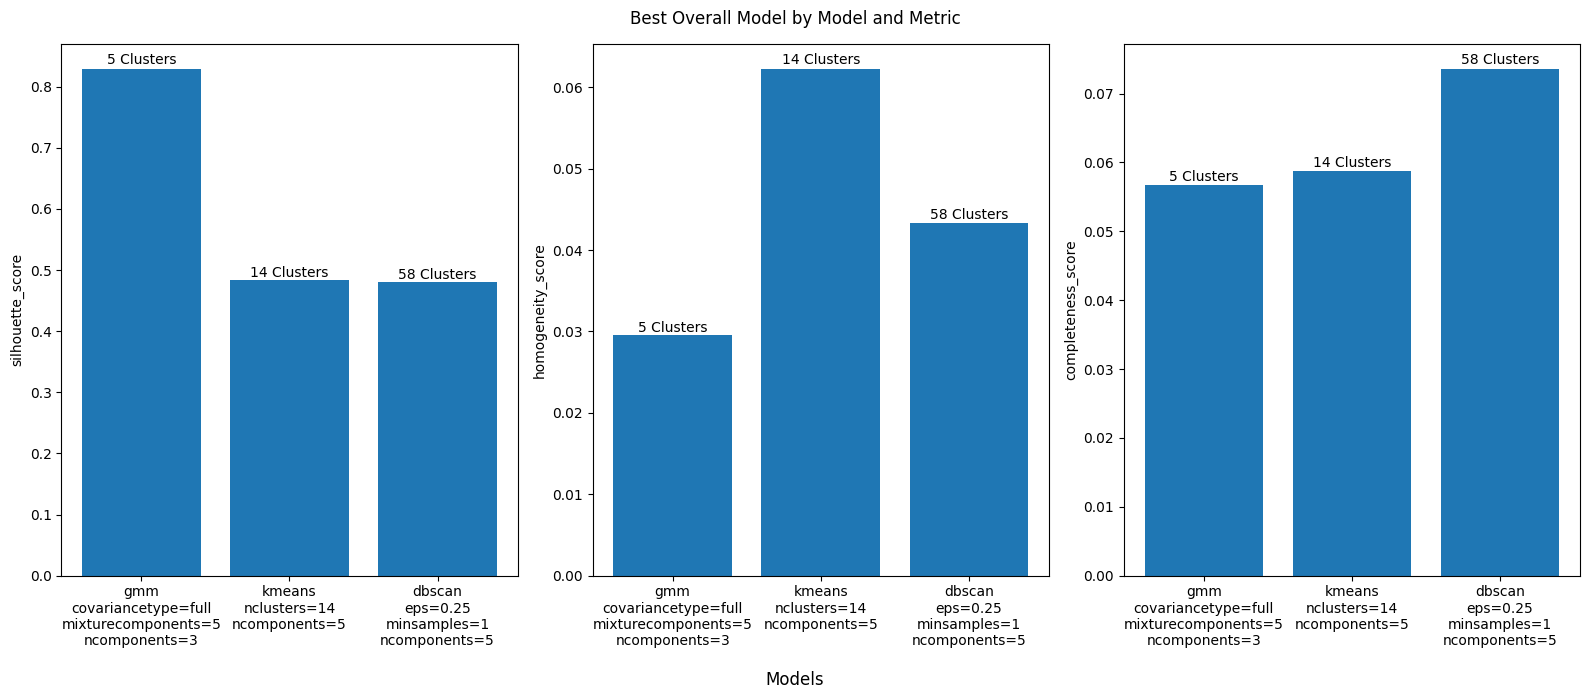

In [192]:
# Because the concatenation is occuring in the same order that the models were generated, we don't need to worry about special mapping methods
model_evaluation_norm_df.index = n_clusters_per_model.iloc[2:].index # ignoring the song_id and genre_id columns

best_norm_models = model_evaluation_norm_df.sort_values(by=['model', 'avg_composition'], ascending=[True, False]).drop_duplicates(subset='model').index.tolist()
best_norm_models = model_evaluation_df.loc[best_norm_models].reset_index(names='model_id')
best_norm_models.sort_values(by=metrics[0], ascending=False, inplace=True) # Sort the first chart, and retain the model order for the last two

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,7))

for i in range(3):
    
    bar = ax[i].bar(
        best_norm_models.loc[:, 'model_id'].str.replace('_', '\n'),
        best_norm_models.loc[:, metrics[i]],
        label=best_norm_models.loc[:, 'model_id'].tolist()
    )
    
    bar_labels = [f"{n_clusters} Clusters" for n_clusters in best_norm_models.loc[:, 'n_clusters']]
    
    rects = ax[i].patches
    
    for rect, label in zip(rects, bar_labels):
        ax[i].text(
            rect.get_x() + rect.get_width() / 2,
            1.01 * rect.get_height(),
            label,
            ha='center'
            )
    
    ax[i].set_ylabel(metrics[i])

fig.supxlabel("Models")
fig.suptitle("Best Overall Model by Model and Metric")
fig.tight_layout();

Based on the best overall models' performance across these metrics, the `GaussianMixture` and the `KMeans` models are the two best models. On the one hand, the `GaussianMixture` model has a significantly `silhouette` score than the two other model classes, the `KMeans` model performs best or second best across all of them. However, it's still concerning that these models perform so poorly against the validation label set. With that in mind it is worth looking at the distribution the genres in the dataset they're based on:

<h4>Genre balance</h4>

Checking the balance of the genre classes

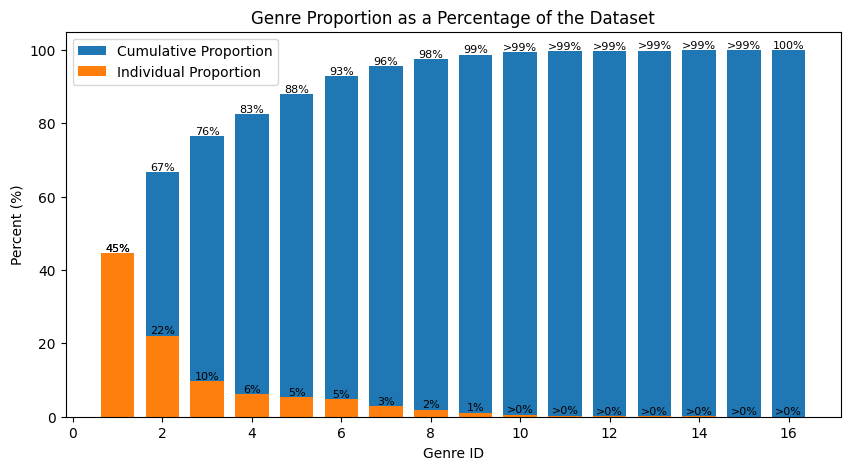

In [193]:
genre_balance = validation_df.loc[:, ['song_id', 'genre_id']].drop_duplicates().copy()
genre_balance = genre_balance.loc[:, ['genre_id']].value_counts()
genre_balance = 100 * genre_balance / NUM_SONGS
n_genres = len(genre_balance)
cum_genre_distribution = np.tri(n_genres) @ genre_balance

genre_dists = [
    cum_genre_distribution,
    genre_balance.values
]

labels = [
    "Cumulative Proportion",
    "Individual Proportion"
]

plt.figure(figsize=(10, 5))

x = range(1,17)

for j, genre_dist in enumerate(genre_dists):
    plt.bar(
        x,
        genre_dist,
        width=.75,
        label=labels[j]
    )
    
    plt.ylabel("Percent (%)")
    plt.xlabel("Genre ID")
    
    for i in range(n_genres):
        proportion = genre_dist[i]
        
        if proportion > 99 and proportion < 100:
            data_label = f">{np.floor(proportion):.0f}%"
        elif proportion > 0 and proportion < 1:
            data_label = f">{np.floor(proportion):.0f}%"
        else:
            data_label = f"{np.round(proportion):.0f}%"
        
        plt.text(
            i+1,
            genre_dist[i] + .5,
            data_label,
            fontsize=8,
            ha='center'
        )
    
plt.title("Genre Proportion as a Percentage of the Dataset")
plt.legend();

This distribution can provide some insight into why the best models for the `silhouette` score alone gravitated towards 8-10 clusters, when 10 genres comprise almost all of the data. This extreme skew also sheds light on why every model had difficulty achieving high `homogeneity` and `completeness` scores. Although this skew could suggest that the `DBSCAN` model would be preferrable due to its high `silhouette` score in conjunction with the fact that it does not need to have a predefined number of clusters, its main weakness is that is it not well suited to the task of predicting new genres. The `GaussianMixture` model, on the other hand, can predict cluster labels with new data and performs similarly on the `silhouette` score as `DBSCAN`. Therefore the 5 cluster `GaussianMixture` model seems to be the best choice, because it has the best combination of features between the `KMeans` and `DBSCAN` models - which can be applied in the future when more training data is available. Due to the discrepancy between the generated clusters and the actual number of clusters, we can consider the clusters as super-genres instead of specific genres/sub-genres.

Let's take a look at the composition of each of its clusters:

In [ ]:
# # The best model had the following characteristics:
# # model = 'gmm'
# # covariance_type = 'full'
# # mixture components = 5
# # principal components = 3
# best_model = 'gmm_covariancetype=full_mixturecomponents=5_ncomponents=3'

# best_model_genre_breakdown = song_genre.loc[:, ['genre_id', best_model]].groupby(best_model).agg(list).reset_index(names='cluster_id')
# best_model_genre_breakdown.loc[:, 'n_genres'] = best_model_genre_breakdown.loc[:, 'genre_id'].apply(lambda x: len(x))

# for i in range(5):
#     a = Counter(best_model_genre_breakdown.iloc[i, 1])

# a.items()

dict_items([(15, 9), (11, 7), (12, 3), (5, 4), (1, 6), (7, 4), (3, 1)])

In [ ]:
# The best model had the following characteristics:
# model = 'gmm'
# covariance_type = 'full'
# mixture components = 5
# principal components = 3
best_model = 'gmm_covariancetype=full_mixturecomponents=5_ncomponents=3'

best_model_genre_breakdown = song_genre.loc[:, ['genre_id', best_model]].groupby([best_model, 'genre_id']).agg('size').reset_index()
best_model_genre_breakdown.columns =['cluster', 'genre_id', 'counts']
best_model_genre_breakdown = pd.pivot(
    best_model_genre_breakdown,
    index='cluster',
    columns='genre_id',
    values='counts'
    )
best_model_genre_breakdown.fillna(0, inplace=True)
best_model_genre_breakdown.loc['row_total'] = best_model_genre_breakdown.sum(axis=0)
best_model_genre_breakdown.loc[:, 'col_total'] = best_model_genre_breakdown.sum(axis=1)
best_model_genre_breakdown

genre_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,col_total
cluster,,,,,,,,,,,,,,,,,
0,0.0,488.0,222.0,78.0,35.0,67.0,1.0,30.0,47.0,2.0,3.0,0.0,34.0,17.0,0.0,28.0,1052.0
1,2.0,2139.0,958.0,489.0,322.0,81.0,3.0,297.0,74.0,28.0,3.0,0.0,31.0,1.0,1.0,195.0,4624.0
2,0.0,109.0,159.0,13.0,16.0,11.0,4.0,0.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,40.0,357.0
3,0.0,136.0,83.0,39.0,25.0,22.0,0.0,10.0,2.0,9.0,0.0,0.0,2.0,0.0,0.0,41.0,369.0
4,0.0,6.0,0.0,1.0,0.0,4.0,0.0,4.0,0.0,0.0,0.0,7.0,3.0,0.0,0.0,9.0,34.0
row_total,2.0,2878.0,1422.0,620.0,398.0,185.0,8.0,341.0,124.0,39.0,6.0,7.0,74.0,18.0,1.0,313.0,6436.0


In [253]:
# Distribution of genres across clusters
genre_cluster_distribution = best_model_genre_breakdown.iloc[:5, :16] /  best_model_genre_breakdown.iloc[5, :16]
genre_cluster_distribution

genre_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
cluster,,,,,,,,,,,,,,,,
0,0.0,0.169562,0.156118,0.125806,0.087940,0.362162,0.125,0.087977,0.379032,0.051282,0.5,0.0,0.459459,0.944444,0.0,0.089457
1,1.0,0.743224,0.673699,0.788710,0.809045,0.437838,0.375,0.870968,0.596774,0.717949,0.5,0.0,0.418919,0.055556,1.0,0.623003
2,0.0,0.037874,0.111814,0.020968,0.040201,0.059459,0.500,0.000000,0.008065,0.000000,0.0,0.0,0.054054,0.000000,0.0,0.127796
3,0.0,0.047255,0.058368,0.062903,0.062814,0.118919,0.000,0.029326,0.016129,0.230769,0.0,0.0,0.027027,0.000000,0.0,0.130990
4,0.0,0.002085,0.000000,0.001613,0.000000,0.021622,0.000,0.011730,0.000000,0.000000,0.0,1.0,0.040541,0.000000,0.0,0.028754


In [261]:
genre_cluster_distribution.loc[0:0].sum(axis=0)

genre_id
0     0.000000
1     0.169562
2     0.156118
3     0.125806
4     0.087940
5     0.362162
6     0.125000
7     0.087977
8     0.379032
9     0.051282
10    0.500000
11    0.000000
12    0.459459
13    0.944444
14    0.000000
15    0.089457
dtype: float64

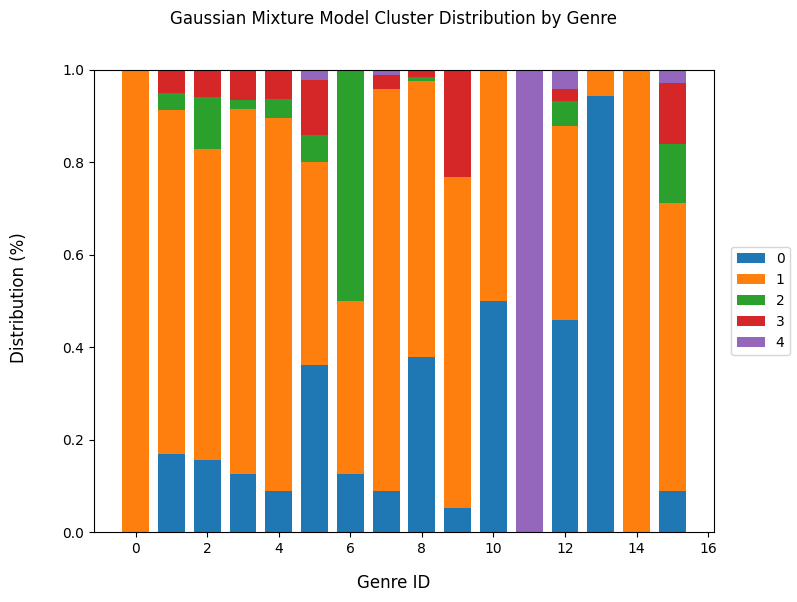

In [282]:
fig, ax = plt.subplots(figsize=(8,6))

bottom = 0
for cluster in genre_cluster_distribution.index:
    if cluster > 0:
        bottom = genre_cluster_distribution.loc[:cluster-1].sum(axis=0)
    
    ax.bar(
        genre_cluster_distribution.columns,
        genre_cluster_distribution.loc[cluster],
        bottom = bottom,
        label=cluster,
        width=.75
    )

fig.suptitle("Gaussian Mixture Model Cluster Distribution by Genre")
fig.supylabel("Distribution (%)")
fig.supxlabel("Genre ID")
fig.legend(loc='outside center right');

### New

In [197]:
eps_list = np.arange(.25, .875, .125)
min_samples_list = range(1, 10, 2)

model_metrics = [[]] * len(poss_principal_components) * len(eps_list) * len(min_samples_list)
model_metrics_columns = [
    "model",
    "inertia",
    "silhouette_score",
    "homogeneity_score",
    "completeness_score",
]
print(len(model_metrics))
row_index = 0

for n_components in poss_principal_components:
    for eps in eps_list:
        for min_samples in min_samples_list:
            dbscan = DBSCAN(
                eps=np.round(eps, 1), # .3 was returned with a floating point error
                min_samples=min_samples,
                n_jobs=-1
            ).fit(data_scaled)            
            
            # Store the cluster labeling by each model
            model_name = f"dbscan_pca={n_components}_eps={eps}_minsamples={min_samples}"
            song_genre.loc[:, model_name] = dbscan.labels_
            print(model_name)
            
            # Generate 1 metrics row per model
            model_metrics[row_index] = [
                model_name,
                None, # inertia
                silhouette_score(data_pca, dbscan.labels_),
                homogeneity_score(song_genre.genre_id, dbscan.labels_),
                completeness_score(song_genre.genre_id, dbscan.labels_)
            ]
            
            row_index += 1
            # break
        break
    break

song_genre

model_metrics_df = pd.DataFrame(model_metrics)
model_metrics_df.columns = model_metrics_columns
model_metrics_df

75
dbscan_pca=3_eps=0.25_minsamples=1
dbscan_pca=3_eps=0.25_minsamples=3
dbscan_pca=3_eps=0.25_minsamples=5
dbscan_pca=3_eps=0.25_minsamples=7
dbscan_pca=3_eps=0.25_minsamples=9


,model,inertia,silhouette_score,homogeneity_score,completeness_score
0,dbscan_pca=3_eps=0.25_minsamples=1,None,-0.534319,0.209765,0.163931
1,dbscan_pca=3_eps=0.25_minsamples=3,None,0.435600,0.047339,0.071557
2,dbscan_pca=3_eps=0.25_minsamples=5,None,0.481041,0.031808,0.056654
3,dbscan_pca=3_eps=0.25_minsamples=7,None,0.469118,0.027540,0.053012
4,dbscan_pca=3_eps=0.25_minsamples=9,None,0.471763,0.024060,0.049731
...,...,...,...,...,...
70,NaN,None,NaN,NaN,NaN
71,NaN,None,NaN,NaN,NaN
72,NaN,None,NaN,NaN,NaN
73,NaN,None,NaN,NaN,NaN


In [198]:
model_metrics_df = pd.DataFrame(model_metrics)
model_metrics_df.columns = model_metrics_columns
model_metrics_df

,model,inertia,silhouette_score,homogeneity_score,completeness_score
0,dbscan_pca=3_eps=0.25_minsamples=1,None,-0.534319,0.209765,0.163931
1,dbscan_pca=3_eps=0.25_minsamples=3,None,0.435600,0.047339,0.071557
2,dbscan_pca=3_eps=0.25_minsamples=5,None,0.481041,0.031808,0.056654
3,dbscan_pca=3_eps=0.25_minsamples=7,None,0.469118,0.027540,0.053012
4,dbscan_pca=3_eps=0.25_minsamples=9,None,0.471763,0.024060,0.049731
...,...,...,...,...,...
70,NaN,None,NaN,NaN,NaN
71,NaN,None,NaN,NaN,NaN
72,NaN,None,NaN,NaN,NaN
73,NaN,None,NaN,NaN,NaN
